# **MHIST computer vision model: Training and Tuning**
This is part of an end-to-end machine learning project. Please see the README for a more complete explanation of the decisions I made for models, tuning, tracking, deployment, and CI/CD.

## **Data**

### Description

**Paper:** A Petri Dish for Histopathology Image Analysis (https://arxiv.org/abs/2101.12355).

**GitHub link:** https://bmirds.github.io/MHIST/

**Description:**

MHIST is minimalist in that it comprises a straightforward binary classification task of fixed-size colorectal polyp images, a common and clinically-significant task in gastrointestinal pathology. MHIST contains 3152 fixed-size images, each with a gold-standard label determined from the majority vote of seven board-certified gastrointestinal pathologists, that can be used to train a baseline model without additional data processing. MHIST is not an equally balanced dataset that contains different numbers of images per class:

(a) **2162 images** per class HP: hyperplastic polyp (benign),

(b) **990 images** per class SSA: sessile serrated adenoma (precancerous).

Availability: Publicly available (for academic purposes).

Resources needed: CPU

Data size: 2175 train data + 977 test data.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9420597/

Histopathological images are the imaging of tissue sections under a microscope. Histopathological images contain a higher degree of information density, and an image can contain elements such as nuclei, cells, tissues, and stroma that are different in structure and texture. However, reducing the resolution will lead to a great loss of information in WSI, which will lead to a decrease in the accuracy of the model, especially in tasks such as cell nucleus identification and tissue structure classification that need to be analyzed by pixel-level features.

They developed a deep model to fuse the features of each patch and preserve their spatial relative positional relationship. The fusion network consists of several fully connected layers with dropout.

Wang et al. proposed a system based on deep learning that can detect malignant melanoma in WSIs of eyelid.

In [1]:
from google.colab import drive
import os
import sys
print(sys.version) # Python version 3.10.12
!lsb_release -a # Ubuntu 22.04.3 LTS (jammy)

PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/projects/MHIST"
IMAGES_DIR = 'images/'
drive.mount('/content/drive')
%cd $PROJECT_DIR

3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/projects/MHIST


In [2]:
# Load CSV files
import pandas as pd

"""
annotations.csv contains metadata, in it's original format

trainset.csv and trainset.csv have the following columns:
'name' : MHIST_<code>.png # image codes are 3 letters long
'experts' = 0 through 7   # int
'label' = 0 or 1          # binary label
"""

# Training set samples: 2175
# Test set samples: 977

annotations = pd.read_csv('annotations.csv')
train_df = pd.read_csv('artifacts/trainset_info.csv')
test_df = pd.read_csv('artifacts/testset_info.csv')

print('annotations.shape', annotations.shape)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)
annotations.head(), train_df.head(), test_df.head()

annotations.shape (3152, 4)
train_df.shape (2175, 3)
test_df.shape (977, 3)


(      Image Name Majority Vote Label  \
 0  MHIST_aaa.png                 SSA   
 1  MHIST_aab.png                  HP   
 2  MHIST_aac.png                 SSA   
 3  MHIST_aae.png                  HP   
 4  MHIST_aaf.png                 SSA   
 
    Number of Annotators who Selected SSA (Out of 7) Partition  
 0                                                 6     train  
 1                                                 0     train  
 2                                                 5     train  
 3                                                 1     train  
 4                                                 5     train  ,
             name  experts  label
 0  MHIST_aaa.png        6      1
 1  MHIST_aab.png        0      0
 2  MHIST_aac.png        5      1
 3  MHIST_aae.png        1      0
 4  MHIST_aaf.png        5      1,
             name  experts  label
 0  MHIST_aag.png        2      0
 1  MHIST_aah.png        2      0
 2  MHIST_aaq.png        5      1
 3  MHIST_aar.png   

###**Class imbalance**

The majority class is HP: hyperplastic polyp (benign). The training set has 71% HP samples, and the testing set has 63% HP samples. Hassanpour Lab has already provided a split for the train and test sets, which I used because they are already imbalanced. The imbalance is not identical, but it is similar.

  Partition Majority Vote Label  Samples
2     train                  HP     1545
3     train                 SSA      630
0      test                  HP      617
1      test                 SSA      360


<Axes: xlabel='Partition', ylabel='Samples'>

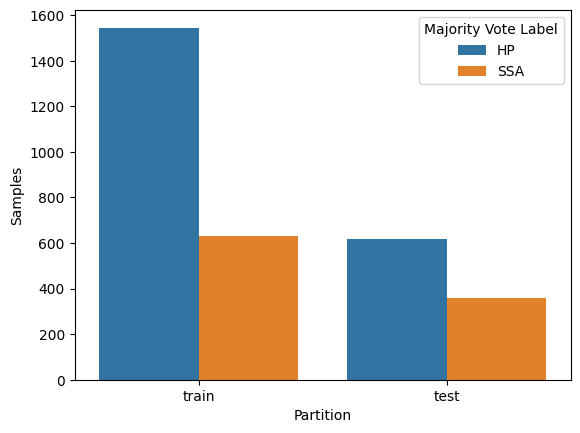

In [15]:
# Visualize Class Imbalance
import seaborn as sns

#Create a df of counts of label classes for the training and test sets
grouped = annotations.groupby(['Partition', 'Majority Vote Label']).size().reset_index(name='Samples')
grouped = grouped.sort_values(by='Partition', ascending=False)
print(grouped)

sns.barplot(x = 'Partition', y = 'Samples', hue = 'Majority Vote Label', data=grouped)

In [23]:
percents = grouped.groupby('Partition', group_keys=True)['Samples'].apply(lambda x: x / float(x.sum())).reset_index()
print(f"Percent HP in training set: {percents.loc[2,'Samples']:.1%}")
print(f"Percent HP in test set: {percents.loc[0,'Samples']:.1%}")

Percent HP in training set: 71.0%
Percent HP in test set: 63.2%


### **Visualize data**

Random image path: images/MHIST_bps.png
(224, 224, 3)
Max pixel intensity: 255


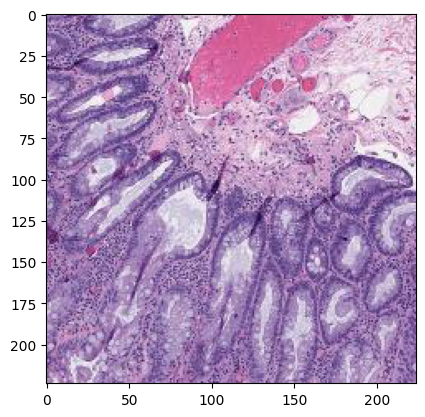

In [27]:
# Number of features: 224*224*3= 150528
# Number of training set data points (instances): 2175
import skimage
import matplotlib.pyplot as plt

def visualize_scan(path):
  img = skimage.io.imread(path)
  print(img.shape)
  print('Max pixel intensity:', img.max())
  plt.imshow(img)
  plt.show()

  # choose a random image from MHIST dataset
import random
rand_img_path = os.path.join(IMAGES_DIR, random.choice(annotations['Image Name']))
print('Random image path:', rand_img_path)
visualize_scan(rand_img_path)

### **Standardize the images**
These images have an unusual color-space: they're mostly purple! I decided to normalize the images based on the mean and standard deviation of the pixel data. I set up transforms based on 0.0 mean and 1.1 standard deviation, then calculated the new mean and standard deviation for the pixel data in the dataset.

Code is from: https://www.kaggle.com/code/kozodoi/computing-dataset-mean-and-std


In [ ]:
# Calculate pixel MEAN and STD in three steps:
IMAGE_SIZE  = 224

# Use this to find the mean and std of the training data,
# then create Dataset and Data Loader
zero_mean = [0.0, 0.0, 0.0]
one_std =  [1.0, 1.0, 1.0]

##### COMPUTE PIXEL SUM AND SQUARED SUM

# Step 1. Define placeholders to store two batch-level stats:
# sum and squared sum of pixel values. The first will be used to
# compute the mean, the second will be needed for standard deviation calculations.
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# Step 2. Loop through the training images (not test data).
# Add up sum and squared sum values.
for batch_i, batch in tqdm(enumerate(train_loader), total=num_batches):
    images = batch['image'] # Tensor size (29, 224, 224, 3)
    psum    +=  images.sum(      axis = [0, 2, 3])
    psum_sq += (images ** 2).sum(axis = [0, 2, 3])

# 3. Perform final calculations to obtain (training) dataset MEAN and STD
count = TRAIN_LEN * IMAGE_SIZE * IMAGE_SIZE
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
rounded_mean = [round(x, 3) for x in total_mean.detach().tolist()]
rounded_std = [round(x, 3) for x in total_std.detach().tolist()]

print('Training data stats:')
print(f'train_mean = {rounded_mean}')
print(f'train_std =  {rounded_std}')

### Custom PyTorch Transforms and Dataset

In [3]:
import torch
from torchvision import transforms

# Don't resize nor crop. These are medical images, so we don't want to lose
# image integrity. Also, most models, like ViT expect images to be 224x224 pixels.

# ToTensor: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a
# torch.FloatTensor with shape (C x H x W) in the range [0.0, 1.0]

# From ImageNet images:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# For Normalize: (calculated from the training data per channel)
train_mean = [0.738, 0.649, 0.775]
train_std =  [0.197, 0.244, 0.17]

# Flatten data for FC
DEFAULT_FC_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    transforms.Lambda(lambda x: torch.flatten(x))
])

# Don't need to flatten our 2-D, 3-channel image data for ViT
DEFAULT_VIT_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

# We don't need a different transform for test sets here because
# we're only pre-processing images, not adding synthetic data

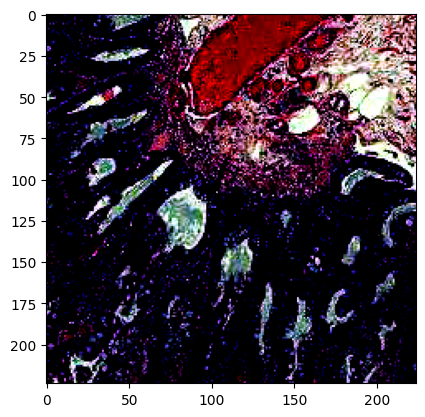

In [34]:
# View sample image with standardized color channels
from PIL import Image
import numpy as np
image_PIL = Image.open(rand_img_path).convert('RGB')
transformed = DEFAULT_VIT_TRANSFORMS(image_PIL)
image_np = transformed.numpy().transpose((1, 2, 0))
image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.pause(0.001)  # pause a bit so plot is updated

In [4]:
from PIL import Image
from torch.utils.data import Dataset

# Custom Dataset class:
class MHIST_dataset(Dataset):
    def __init__(self, df, images_dir=IMAGES_DIR, transform=None):
        self.df = df
        self.images_dir = images_dir
        if transform == None:
            print("Error: missing transform for MHIST_dataset")
            raise ValueError("Error: missing transform for MHIST_dataset")
        self.transform = transform


    def __len__(self):
        return len(self.df)


    # getitem() returns {image tensor, label int64, image filename}
    def __getitem__(self, idx):
        # df['label'] = 0 or 1 (int64)
        # df['name'] ex: MHIST_abc.png
        row = self.df.iloc[idx]
        full_path = os.path.join(self.images_dir, row['name'])
        image_PIL = Image.open(full_path).convert('RGB')
        if image_PIL is None:
            raise FileNotFoundError(full_path)
        if self.transform:
            image = self.transform(image_PIL) # includes ToTensor

        return {
            'image': image,
            'label': row['label'],
            'filename': row['name'],
        }

## Models

### Simple FC model
After some experimentation, the best fully-connected MLP model I could find for this dataset is actually a simple one, in this case: only three layers. MLP models quickly overfit to the dataset during training, so small learning rates are helpful. A learning rate scheduler helps as did Xavier initialization.

In the end, the weighted F1-score was 0.73 on the validation set. This was an interesting experiment, but the results are not satisfactory for medical applications. A dropout layer would likely help with overfitting, but there are better options for computer vision.

In [3]:
from torch.nn import Module, Linear
from torch.nn.functional import relu

# Number of features: 224*224*3= 150528

class SimpleFC(Module):
    def __init__(self,D_in,H1,H2,H3,D_out):
        super().__init__()
        self.layer1 = Linear(D_in,H1)
        self.layer2 = Linear(H1,H2)
        self.layer3 = Linear(H2,H3)
        self.outlayer = Linear(H3,D_out)
    def forward(self,x):
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))
        x = relu(self.layer3(x))
        return self.outlayer(x)

fc = SimpleFC(150528, 2352, 2352, 294, 1)
fc

SimpleFC(
  (layer1): Linear(in_features=150528, out_features=2352, bias=True)
  (layer2): Linear(in_features=2352, out_features=2352, bias=True)
  (layer3): Linear(in_features=2352, out_features=294, bias=True)
  (outlayer): Linear(in_features=294, out_features=1, bias=True)
)

### **ViT**
I used TIMM to download the ViT model and change the output to binary. I set `pretrained = True` and froze all except the head to fine-tune the model with pretrained weights. This version is ViT base and it breaks (224 x 224) images into 16 patches.

In [5]:
!pip install -q timm # CPU-only version is: timm[torch-cpu]
import timm
VIT_MODEL_TYPE = 'vit_base_patch16_224.augreg2_in21k_ft_in1k'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.9 MB/s eta 0:00:00


## Training

In [6]:
# For MLflow tracking server

!pip install -q mlflow
!pip install -q boto3
!pip install -q awscli
# !aws configure
!aws --version # aws-cli/1.33.15 Python/3.10.12 Linux/6.1.85+ botocore/1.34.133

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [9]:
!pip install -q awscli


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 24.7 MB/s eta 0:00:00


In [7]:
import os
import math
import time
import logging
import numpy as np
import pandas as pd

# For data
from torch.utils.data import DataLoader, WeightedRandomSampler

# # For training
# TRAIN_DF = train_df
# TEST_DF = test_df

# For inference
TRAIN_DF = None
TEST_DF = test_df

# For training
import torch
# print('torch.version', torch.__version__) # 2.3.0+cu121
# print('torch.version.cuda', torch.version.cuda) # 12.1
# print('torch.backends.cudnn.version', torch.backends.cudnn.version()) # 8906

import copy
from tqdm import tqdm
from torch.nn import Conv2d, BCEWithLogitsLoss, init # for init.xavier_uniform_
from torch.optim import lr_scheduler, Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report

# For tracking
import mlflow
'mlflow', mlflow.__version__ # 2.14.1
MLFLOW_SERVER = "http://13.52.243.246:5000"
MLFLOW_MODEL_PATH = 'onnx_artifacts' #1.4G
MLFLOW_DEFAULT_EXPERIMENT = 'MHIST FC (binary classification)'

# Checkpoints are saved in PyTorch format (by using torch.save model.state_dict)
# PyTorch uses current device (CPU or GPU)
# FC model should have a single output of logits (positive_prob = sigmoid(logit))
DEFAULT_MODEL_PATH = 'MHIST_model.pt' # Relative path for saving and loading checkpoints
DEFAULT_LR = 1e-6
DROP_LAST_BATCH = False
DEFAULT_LOGGER_NAME = "MHIST training session"

# To save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

class TrainingSession:
  def __init__(self,
               train_transform=None,
               val_transform=None,
               path_for_resuming = None, # resume from local path if not None (not used for saving best model)
               resume_from_object = False, # resume from model object
               model = None, # if not resume_from_object, FC model is initialized to random
               model_type = 'FC', # 'FC' or 'VIT'
               batch_size = None,
               eval_on='loss',
               enable_tracking=False,
               logger=None,
               ):
    self.model_type = model_type
    self.logger = logging.getLogger(DEFAULT_LOGGER_NAME) if logger is None else logger
    self.enable_tracking = enable_tracking

    # Training Setup
    self.random = 42
    self.label_names = ['HP', 'SSA'] # HP = 0, SSA = 1
    self.learning_rate = None # will be set before training
    self.optimizer = None     # will be set before training
    self.scheduler = None     # will be set before training
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # <class 'torch.device'>
    self.batch_size = self.__get_batch_size(batch_size)
    self.train_transform, self.val_transform = self.__get_transforms(train_transform, val_transform) # use default for None
    self.loader_dict = self.__get_loaders(TRAIN_DF, TEST_DF) # might return None or dict['train'] = None
    self.model, self.best_model_wts = self.__model_init(path_for_resuming, resume_from_object, model) # resume from path if it is not None

    # For saving the best model
    self.eval_on = eval_on      # eval model on this metric (can't change this later)
    self.best_metric = None     # will be set before training
    self.best_model_dest = None # will be set before training
    self.precision_goal = 0.8
    self.recall_goal = 0.8
    self.f1_goal = 0.8
    self.accuracy_goal = 0.8


  def __get_batch_size(self, batch_size):
      if batch_size is None:
        print('Using default batch size')
        return 32 if torch.cuda.is_available() else 4
      return batch_size


  def __get_transforms(self, train_transform, val_transform): # check for None values
    print('Setting up data:')
    if self.model_type == 'FC':
        print('Using FC transforms')
        if train_transform is None:
          train_transform = DEFAULT_FC_TRANSFORMS
        if val_transform is None:
          val_transform = DEFAULT_FC_TRANSFORMS

    elif self.model_type == 'VIT':
        print('Using ViT transforms')
        if train_transform is None:
          train_transform = DEFAULT_VIT_TRANSFORMS
        if val_transform is None:
          val_transform = DEFAULT_VIT_TRANSFORMS
    return train_transform, val_transform


  def __get_loaders(self, train_df=None, test_df=None):

    if test_df is None:
      print("Error: can't evaluate or run inference without test_df.")
      return None

    elif train_df is None: # don't need to shuffle
      val_loader = DataLoader(MHIST_dataset(test_df, transform=self.val_transform),
                              batch_size=self.batch_size,
                              shuffle=False,
                              drop_last=DROP_LAST_BATCH)
      loader_dict = {'train':None, 'val':val_loader}
      test_samples = len(test_df) # loader has length = num_batches
      print(f"No training set. Model is ready for inference on {test_samples} samples.")
      print('batch_size', self.batch_size, 'val_num_batches', math.floor(test_samples/self.batch_size))
      return loader_dict # Training loader is empty!

    else: # we have train_df and test_df
      # Load the WeightedRandomSampler to balance the training data (not validation data)
      # This will randomly oversample the minority class and undersample majority class during training

      # WeightedRandomSampler
      # majority samples = 1545
      # minority samples =  630
      #              len = 2175
      samples_weights = np.load('artifacts/samples_weights.npy') # dtype float64
      sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
      # print('WeightedRandomSampler len:', len(sampler), 'dtype', samples_weights.dtype)

      print('train_df len', len(train_df), 'test_df len', len(test_df))
      train_loader = DataLoader(MHIST_dataset(train_df, transform=self.train_transform),
                                batch_size=self.batch_size,
                                sampler=sampler,
                                drop_last=DROP_LAST_BATCH)
      val_loader = DataLoader(MHIST_dataset(test_df, transform=self.val_transform),
                              batch_size=self.batch_size,
                              shuffle=False,
                              drop_last=DROP_LAST_BATCH)
      loader_dict = {'train':train_loader, 'val':val_loader}

      train_samples = len(train_df)
      test_samples = len(test_df)
      print(f"Training with {len(loader_dict['train'])} batches, validating with {len(loader_dict['val'])} batches with batch_size {self.batch_size}")
      print('train_num_batches', math.ceil(train_samples/self.batch_size), 'and val_num_batches', math.ceil(test_samples/self.batch_size))
      return loader_dict


  @staticmethod
  def initialize_weights(module):
      if type(module) == Linear or type(module) == Conv2d:
          init.xavier_uniform_(module.weight)


  # Log gradient summary before training
  def __grad_summary(self):
      if mhist_logger.getEffectiveLevel() <= logging.WARNING:
          layers = list(self.model.children())
          total_layers_training = 0
          # print('Model layer gradients:\n', layers)

          # Get the parameters of the first three layers
          for i, layer in enumerate(layers, 1):
              # count total tensors and tensors that require grad
              print(f"Layer {i}:")
              total_tensors = 0
              num_training = 0
              for param in layer.parameters():
                  total_tensors += 1 # two tensors per linear layer: weights and biases
                  if param.requires_grad:
                      num_training += 1
                  # print(param.dtype) # Debug
                  # print(param.shape) # Debug

              if num_training==0 and total_tensors>0: # fully frozen
                  print(f"  frozen")
              elif total_tensors>0:
                  total_layers_training += 1
                  print(f"  tensors that require grad: {num_training}/{total_tensors}") # Info
              else:
                  print(f"  no tensors")
          print('---------------------------------')
          print('Training', total_layers_training, 'layers of', len(layers), 'total')


  def __freeze_all_but_head(self):
      # Freeze all params
      for param in self.model.parameters():
          param.requires_grad = False

      # Unfreeze last layer
      if hasattr(self.model, 'head'):
          for param in self.model.head.parameters():
              param.requires_grad = True
      else:
          print("Error: Can't unfreeze classification head")


  def __alloc_new_model(self, model_obj): # this won't init weights
      # SimpleFC model
      # Number of input features: 224*224*3= 150528
      if model_obj is None and self.model_type == 'FC':
        print('Allocating a new SimpleFC')
        model_obj = SimpleFC(150528, 2352, 2352, 294, 1)

      elif model_obj is None and self.model_type == 'VIT':
        model_obj = timm.create_model(
            model_name=VIT_MODEL_TYPE,
            pretrained=True,
            num_classes=1, # change number of outputs in classification head
        )
        # print('vit.head', model_obj.head) # Linear(in_features=768, out_features=1, bias=True)
        print(f"Allocating a new model from timm: {model_obj.default_cfg['architecture']} with pretrained weight tag: {model_obj.default_cfg['tag']}")
      return model_obj


  def __model_init(self, path_for_resuming, resume_from_object, model_obj): # resume from path if it is not None
    # If we're resuming from object and path, resuming from object is given priority
    # This way, we won't overwrite memory, if we accidentally pass in a path as well
    # If we meant to resume from a path, we can always retry because it's on disk
    if resume_from_object: # else use model passed into the training method without altering the weights
      if model_obj is None:
          print("Warning: Can't resume because model = None")
          return None, None
      print('Info: Resuming from model object')
      # model_obj returned below

    elif path_for_resuming is not None: # Load weights from disk
      model_obj = self.__alloc_new_model(model_obj) # based on self.model_type
      print('Info: Resuming from saved state dict', path_for_resuming, 'on device', self.device)
      # model weights might not work if we used the default model, above
      model_obj.load_state_dict(torch.load(path_for_resuming, map_location=self.device))

    # Create default model (not resuming from object nor path)
    elif model_obj is None:
      model_obj = self.__alloc_new_model(model_obj) # based on self.model_type
      if self.model_type == 'FC': # don't init ViT pretrained
          print('Info: Initializing model weights with Xavier Uniform')
          model_obj.apply(self.initialize_weights) # Xavier Uniform

    # Load into memory, in case this session makes the weights worse
    # If not resuming from object, use the model that was passed in (which could be different from the currently loaded model)
    print('Loading a copy of initial model weights into memory')
    best_model_wts = copy.deepcopy(model_obj.state_dict())

    return model_obj, best_model_wts # model to train and copy of initial model weights (random or from checkpoint)



                    ### TRAIN/EVAL LOOP ###

  # Wrapper for setting params before running train/eval loop
  def train_and_evaluate(self, model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
                         epochs = 10,
                         freeze_all_but_head = True,
                         learning_rate = None,
                         best_metric = None,
                         best_model_dest = DEFAULT_MODEL_PATH,
                         mlflow_experiment = MLFLOW_DEFAULT_EXPERIMENT,
                         mlflow_run = None):

    if model is not None:
        self.model = model
    if freeze_all_but_head:
        self.__freeze_all_but_head()
    self.__grad_summary()

    if best_metric is not None:
        self.best_metric = best_metric
    elif self.best_metric is None and self.eval_on != 'loss':
        self.best_metric = 0.
    # else: if eval_on == 'loss' then best_metric might be None
    self.best_model_dest = best_model_dest
    print('Evaluating the model on', self.eval_on, 'best_metric =', self.best_metric)

    # Get a list of trainable params to pass into optimizer (for efficiency)
    trainable_tensors = [p for p in self.model.parameters() if p.requires_grad]
    # Init self with default LR and create a new optimizer
    if learning_rate is None and self.learning_rate is None:
        self.learning_rate = DEFAULT_LR
        self.optimizer = Adam(params=trainable_tensors, lr=DEFAULT_LR)

    # Update with new LR (passed into method)
    elif learning_rate is not None:
        if self.learning_rate is None: # init with LR param and new optimizer
            self.optimizer = Adam(params=trainable_tensors, lr=learning_rate)
        else: # update existing LR with new one in existing optimizer
            self.optimizer.param_groups[0]['lr'] = learning_rate
        self.learning_rate = learning_rate
    # else: param is None, so don't update existing LR and optimizer (which are not None)
    print('Initial learning rate', self.learning_rate)

    # Train the model
    if self.enable_tracking:
        # __track_training will call __train_eval_loop()
        self.__track_training(epochs, mlflow_experiment, mlflow_run)
    else: # Don't use MLflow tracking server
        print('Info: Starting training without tracking to MLflow server.')
        self.__train_eval_loop(epochs)

    return self.model # in case we want to freeze/unfreeze, check, or change anything


  def __get_model_hyperparams(self):
    # ViT input: torch.FloatTensor with shape (C x H x W) in the range [0.0, 1.0]
    input_type = {
        'FC':"flattened 3 x 224 x 224 (RGB mode) in range [0.0, 1.0]",
        'VIT':"3 x 224 x 224 (RGB mode) in range [0.0, 1.0]",
    }
    in_feature_shape = 150528 if self.model_type == 'FC' else [3, 224, 224] # (C x H x W)
    return dict(
      model_class=str(self.model.__class__.__name__),
      model_info=str(self.model),
      input_image=input_type[self.model_type],
      num_in_features=in_feature_shape,
      in_feature_dtype = 'torch.float32',
      num_outputs=1,
      label_names=self.label_names,
      test_size='is set with dataframes',
      batch_size=self.batch_size,
      random=self.random,
      device=str(self.device),
      eval_on = self.eval_on,
      best_metric = self.best_metric,
      best_model_dest = self.best_model_dest,
      # logger=get_log_filename(self.logger),
    )


  def __track_training(self, epochs, experiment, run_id):
    mlflow.set_tracking_uri(MLFLOW_SERVER)
    mlflow.set_experiment(experiment)

    # "with" manages context by calling mlflow.end_run() appropriately.
    # Beforehand, it ends any active run. Upon error or exit, it ends this run.
    # run_id = None will start a new run
    with mlflow.start_run(run_id) as run:
        print('\nLogging metrics with server:', mlflow.get_tracking_uri())
        print('MLflow: run_name =', run.info.run_name, 'run_id =', run.info.run_id) # run_id is a UUID
        self.run_id = run.info.run_id # save in case we want to log the model later with self.log_model
        # print('Artifacts stored at:', mlflow.get_artifact_uri())
        print('MLflow Experiment name:', experiment, '\n')
        mlflow.log_params(self.__get_model_hyperparams())

        self.__train_eval_loop(epochs)


  def __train_eval_loop(self, epochs):
    if self.scheduler is None:
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1, last_epoch=-1) # multiply LR by 10% every 5 epochs

    self.model.to(self.device)
    print('Device:', next(self.model.parameters()).device, 'torch.cuda.device_count:', torch.cuda.device_count())
    criterion = BCEWithLogitsLoss()
    steps = 0
    previous_lr = None # To track changes in LR
    start = time.time()

    for epoch in range(epochs):
        # Each epoch has a two phases: training and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                self.model.train()
            else:
                self.model.eval()

            # for each epoch phase:
            epoch_loss    = 0.
            epoch_correct = 0
            epoch_samples = 0
            y = []      # correct labels
            y_pred = [] # pred labels

            for batch_idx, batch in enumerate(tqdm(self.loader_dict[phase])):#, total=len(self.loader_dict[phase])):
                # batch is a dict of:
                # {'image' : tensor of batch_size flattened or [batch,3,224,224] images,
                #  'label' : tensor batch_size integer labels}
                images = batch['image'].to(self.device) # logits dtype torch.float32
                labels = batch['label'].type(torch.FloatTensor).to(self.device) # labels dtype torch.float32

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                # track history only when phase == 'train'
                with torch.set_grad_enabled(phase == 'train'):
                    batch_size = len(labels)
                    logits = self.model(images).squeeze() # output is torch.Size([32, 1])
                    loss = criterion(logits, labels) # BCEWithLogitsLoss
                    preds = (logits > 0).float()

                    # DEBUG: shapes and dtypes
                    # print('\nlabels:', labels.shape, 'dtype', labels.dtype) # torch.float32
                    # print('logits:', logits.shape, 'dtype', logits.dtype) # torch.float32
                    # print('preds:', preds.shape, 'dtype', preds.dtype) # torch.float32
                    num_correct = (preds == labels).sum().item() # this will broadcast if shapes don't match

                    if phase == 'train':
                        loss.backward()
                        self.optimizer.step()
                        steps += 1

                # Update totals and lists
                epoch_loss    += loss.item() * batch_size # TODO: check this
                epoch_correct += num_correct
                epoch_samples += batch_size  # last dataloader batch might be smaller
                y.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                # # DEBUG: First batch (in 'train' phase)
                # if epoch == 0 and batch_idx == 0 and phase == 'train':
                #   labels_np= labels.cpu().numpy()
                #   preds_np= preds.cpu().numpy()
                #   logits_np = logits.squeeze().cpu().detach().numpy()
                #   f1 = f1_score(y, y_pred, average='weighted') # accepts numpy or list
                #   pr_auc = average_precision_score(y, y_pred, average='weighted')
                #   recall = recall_score(y, y_pred, pos_label=1) # recall for positive class
                #   print('Label, Pred, Logit, Correct')
                #   print(np.column_stack((labels_np, preds_np, logits_np, preds_np == labels_np)))
                #   print(f'[Epoch {epoch}, Batch {batch_idx}] Batch loss: {loss.item()/batch_size :.3f}, Accuracy: {float(num_correct)/batch_size :.3f} correct, F1 Score: {f1 :.3f}, Recall for 1: {recall:.3f}')
                #   print(classification_report(y, y_pred))

            # After each epoch phase, update stats:
            epoch_metrics = self.__compute_metrics(phase, epoch_loss, epoch_correct, epoch_samples, y, y_pred)
            if phase == 'train':
              eval_on = self.eval_on
              loss_name = 'loss'
              f1_name = 'f1'
              accuracy_name = 'accuracy'
            else:
              eval_on = 'val_'+self.eval_on
              loss_name = 'val_loss'
              f1_name = 'val_f1'
              accuracy_name = 'val_accuracy'
            if self.enable_tracking:
                mlflow.log_metrics(metrics=epoch_metrics, step=steps)
            print(f"Epoch {epoch+1} ({steps} steps) {phase} Loss: {epoch_metrics[loss_name]:.3f}, {eval_on}: {epoch_metrics[eval_on]}, F1: {epoch_metrics[f1_name]} Accuracy: {epoch_metrics[accuracy_name]:.3f}")

            if phase == 'train':
                # Step LR scheduler
                self.scheduler.step()

                # Check if the learning rate has changed
                current_lr = self.scheduler.get_last_lr()[0]
                if previous_lr is None:
                    previous_lr = current_lr
                elif current_lr != previous_lr:
                    print(f"Epoch {epoch+1} {phase}: Learning rate changed to {current_lr:.6f}")
                    previous_lr = current_lr

        # End of an epoch (train and val)
        if epoch==0:
            epoch_time = time.time() - start
            print(f'Epoch 0 completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best {self.eval_on} score: {self.best_metric}')
    initial_lr = self.optimizer.param_groups[0]['initial_lr']
    final_lr = self.scheduler.get_last_lr()[0]
    print(f'Learning rate: start={initial_lr} final={final_lr}')
    cm = confusion_matrix(y, y_pred)
    print(cm)
    print(classification_report(y, y_pred))

    if self.enable_tracking:
        mlflow.log_metric("time_elapsed", time_elapsed, step=steps)
        self.__log_dict(cm, step=steps)
        self.__save_heatmap(cm) # save image to local and mlflow artifacts
        self.__log_hyperparams(self.optimizer, self.scheduler, criterion)

    # Load best model weights, in case this run was worse
    self.model.load_state_dict(self.best_model_wts)


  def __log_hyperparams(self, optimizer, scheduler, criterion):
        # Adam optimizer
        mlflow.log_params(dict(
            optimizer = optimizer.__class__.__name__,
            initial_lr = self.optimizer.param_groups[0]['initial_lr'],
            final_lr = self.scheduler.get_last_lr()[0],
            weight_decay = optimizer.param_groups[0]['weight_decay']
            ))

        # StepLR Scheduler
        mlflow.log_params(dict( # StepLR
            scheduler = scheduler.__class__.__name__,
            step_size = scheduler.step_size,
            gamma = scheduler.gamma,
            last_epoch = scheduler.last_epoch,
            verbose = scheduler.verbose,
        ))

        # BCEWithLogitsLoss
        mlflow.log_param('loss_function', type(criterion).__name__)


  def __log_dict(self, cm, step):
      # Rows represent the actual classes
      # Columns represent the predicted classes
      mlflow.log_metric("true_negative", cm[0][0], step=step)
      mlflow.log_metric("false_positive", cm[0][1], step=step)
      mlflow.log_metric("false_negative", cm[1][0], step=step)
      mlflow.log_metric("true_positive", cm[1][1], step=step)


  def __save_heatmap(self, cm_numpy):
      plt.figure(figsize=(4, 3))
      sns.heatmap(cm_numpy, annot=True, fmt='d', cmap='Blues')
      plt.title('Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

      # Save and upload image
      model_name = os.path.splitext(os.path.basename(self.best_model_dest))[0] # get filename, remove extension
      image_path = f'artifacts/{model_name}_confusion_matrix.png'
      plt.savefig(image_path) # it's possible that there won't be a best model checkpoint to match this image
      mlflow.log_artifact(image_path)


  def __compute_metrics(self, phase, epoch_loss, epoch_correct, epoch_samples, y, y_pred):
      # print(f'Computing metrics for {phase}')
      # # debug:
      # compare_labels = np.column_stack((logits, preds, labels, preds == labels))
      tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
      metrics = dict(
          loss = epoch_loss/epoch_samples, # average loss per sample (not per batch)
          weighted_precision = precision_score(y, y_pred, average='weighted'),
          weighted_recall = recall_score(y, y_pred, average='weighted'),
          f1 = f1_score(y, y_pred, average='weighted'),
          accuracy = accuracy_score(y, y_pred),
          false_negative_rate = fn / (fn + tp),
          true_positive_rate = tp / (tp + fn) # recall for positive class
      )

      if phase == 'val': # check model for improvement (epoch end)
          improved = False
          # loss improves when minimized, others when maximized
          if self.eval_on == 'loss' and self.best_metric is None:
              self.best_metric = metrics[self.eval_on]
          elif self.eval_on == 'loss' and metrics[self.eval_on] < self.best_metric:
              print(f"Improved validation loss: {metrics['loss']}")
              improved = True
          elif self.eval_on != 'loss' and metrics[self.eval_on] > self.best_metric:
              print(f'Improved validation {self.eval_on}: {metrics[self.eval_on]}')
              improved = True

          if improved and self.__met_goal(metrics):
              print(f'Saving model weights to {self.best_model_dest}')
              torch.save(self.model.state_dict(), self.best_model_dest) #to disk
              best_model_wts = copy.deepcopy(self.model.state_dict()) #to memory
              self.best_metric = metrics[self.eval_on]

          return {'val_'+key: value for key, value in metrics.items()} # add prefix to val metric names
      return metrics


  def __met_goal(self, metrics_dict):
      met_new_goal = False
      if metrics_dict['weighted_precision'] > self.precision_goal:
          print(f"Improved validation weighted_precision: {metrics_dict['weighted_precision']}")
          self.precision_goal = metrics_dict['weighted_precision']
          met_new_goal = True
      if metrics_dict['weighted_recall'] > self.recall_goal:
          print(f"Improved validation weighted_recall: {metrics_dict['weighted_recall']}")
          self.recall_goal = metrics_dict['weighted_recall']
          met_new_goal = True
      if metrics_dict['f1'] > self.f1_goal:
          print(f"Improved validation F1-score: {metrics_dict['f1']}")
          self.f1_goal = metrics_dict['f1']
          met_new_goal = True
      if metrics_dict['accuracy'] > self.accuracy_goal:
          print(f"Improved validation accuracy: {metrics_dict['accuracy']}")
          self.accuracy_goal = metrics_dict['accuracy']
          met_new_goal = True
      return met_new_goal


  @staticmethod
  def __sigmoid(np_outs):
      np_outs = np.clip(np_outs, -50, 50) # prevent np.exp overflow for large values (in case of an issue with preprocessing)
      return 1 / (1 + np.exp(-np_outs))


  # To run batch inference, initalize a session with a model, then run this method (not train)
  # input df path is hard-coded, above, in global var: TEST_DF
  def batch_predict(self):
      self.model.eval()
      self.model.to(self.device)
      dataset = self.loader_dict['val'].dataset
      epoch_np = None
      with torch.no_grad():
          first_batch = True
          for batch in tqdm(self.loader_dict['val']):
              images = batch['image'].to(self.device) # torch.Size([960, 3, 224, 224]) torch.float32
              logits_np = self.model(images).detach().cpu().squeeze().numpy() # shape=(960,) dtype=float32

              positive_probs_np = self.__sigmoid(logits_np) # shape=(960,) dtype=float32
              preds_np = (positive_probs_np > 0.5).astype(int) # shape=(960,) dtype=int64

              labels_np = batch['label'].cpu().squeeze().numpy() # shape=(960,) dtype=int64
              correct_np = np.equal(labels_np, preds_np).astype(int) # shape=(960,) dtype=int64

              filename_np = np.array(batch['filename']) # np objects, shape (960,) filenames are returned as <class 'list'>
              if first_batch:
                  first_batch = False
                  epoch_np = np.column_stack((filename_np, labels_np, logits_np, preds_np, positive_probs_np, correct_np))
              else:
                  batch_np = np.column_stack((filename_np, labels_np, logits_np, preds_np, positive_probs_np, correct_np))
                  epoch_np = np.vstack((epoch_np, batch_np))
      results_df = pd.DataFrame(epoch_np, columns=['filename', 'label', 'logit', 'prediction', 'positive_prob', 'correct'])

      # Convert datatypes to string, float, int
      results_df['filename'] = results_df['filename'].astype('string')
      results_df['logit'] = pd.to_numeric(results_df['logit'], errors='coerce')
      results_df['positive_prob'] = pd.to_numeric(results_df['positive_prob'], errors='coerce')
      results_df['label'] = pd.to_numeric(results_df['label'], errors='coerce').astype('Int64')
      results_df['prediction'] = pd.to_numeric(results_df['prediction'], errors='coerce').astype('Int64')
      results_df['correct'] = pd.to_numeric(results_df['correct'], errors='coerce').astype('Int64')

      # calculate metrics
      y_true = results_df['label'].to_numpy(dtype=int)
      y_prob = results_df['positive_prob'].to_numpy(dtype=int)
      y_pred = results_df['prediction'].to_numpy(dtype=int)
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      metrics = {
          'weighted_precision': precision_score(y_true, y_pred, average='weighted'),
          'weighted_recall': recall_score(y_true, y_pred, average='weighted'),
          'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
          'accuracy': accuracy_score(y_true, y_pred),
          'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
          'roc_auc': roc_auc_score(y_true, y_prob),
          'pr_auc': average_precision_score(y_true, y_prob),
          'false_negative_rate': fn / (fn + tp),
          'true_positive_rate': tp / (tp + fn) # recall for positive class
      }

      return results_df, metrics


### Train FC model

Setting up data:
batch_size 32
train_num_batches 67
val_num_batches 30
Info: Initializing model weights with Xavier Uniform
Loading a copy of initial model weights into memory
Evaluating the model on recall best_metric = 0.0
Initial learning rate 1e-06

Logging metrics with server: http://ec2-3-101-21-63.us-west-1.compute.amazonaws.com:5000
MLflow: run_name = orderly-hound-570 run_id = e29f8e7ed17c4486aec60cc996d93d10
MLflow Experiment name: MHIST FCN (binary classification) 

Device: cuda:0


100%|██████████| 34/34 [00:42<00:00,  1.26s/it]


Epoch 1 train Loss: 0.579, recall: 0.7144168962350781, Accuracy: 0.689
Epoch 1 train: Learning rate changed to 0.000001


100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Improved validation recall: 0.6722222222222223
Saving model weights to artifacts/MHIST_SmallFCN_v1.pt
Epoch 1 val Loss: 0.609, val_recall: 0.6722222222222223, Accuracy: 0.676
Epoch 0 completed in 0m 52s


100%|██████████| 34/34 [00:16<00:00,  2.01it/s]


Epoch 2 train Loss: 0.389, recall: 0.8687910028116214, Accuracy: 0.869


100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Epoch 2 val Loss: 0.581, val_recall: 0.6194444444444445, Accuracy: 0.694


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 3 train Loss: 0.269, recall: 0.9654859218891917, Accuracy: 0.949


100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 3 val Loss: 0.552, val_recall: 0.5694444444444444, Accuracy: 0.710


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


Epoch 4 train Loss: 0.206, recall: 0.976036866359447, Accuracy: 0.977


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 4 val Loss: 0.551, val_recall: 0.5638888888888889, Accuracy: 0.719


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch 5 train Loss: 0.156, recall: 0.9935304990757856, Accuracy: 0.990
Epoch 5 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 5 val Loss: 0.543, val_recall: 0.55, Accuracy: 0.731


100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


Epoch 6 train Loss: 0.136, recall: 0.9990592662276576, Accuracy: 0.995


100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 6 val Loss: 0.542, val_recall: 0.5388888888888889, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


Epoch 7 train Loss: 0.130, recall: 1.0, Accuracy: 0.994


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 7 val Loss: 0.542, val_recall: 0.5416666666666666, Accuracy: 0.735


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


Epoch 8 train Loss: 0.127, recall: 0.9990467111534795, Accuracy: 0.994


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 8 val Loss: 0.543, val_recall: 0.5361111111111111, Accuracy: 0.735


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch 9 train Loss: 0.124, recall: 1.0, Accuracy: 0.994


100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 9 val Loss: 0.543, val_recall: 0.5388888888888889, Accuracy: 0.736


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch 10 train Loss: 0.119, recall: 1.0, Accuracy: 0.997
Epoch 10 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 10 val Loss: 0.544, val_recall: 0.5305555555555556, Accuracy: 0.733
Training complete in 3m 58s
Best recall score: 0.6722222222222223
Learning rate: start=1e-06 final=1e-08
[[525  92]
 [169 191]]
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       617
         1.0       0.67      0.53      0.59       360

    accuracy                           0.73       977
   macro avg       0.72      0.69      0.70       977
weighted avg       0.73      0.73      0.72       977



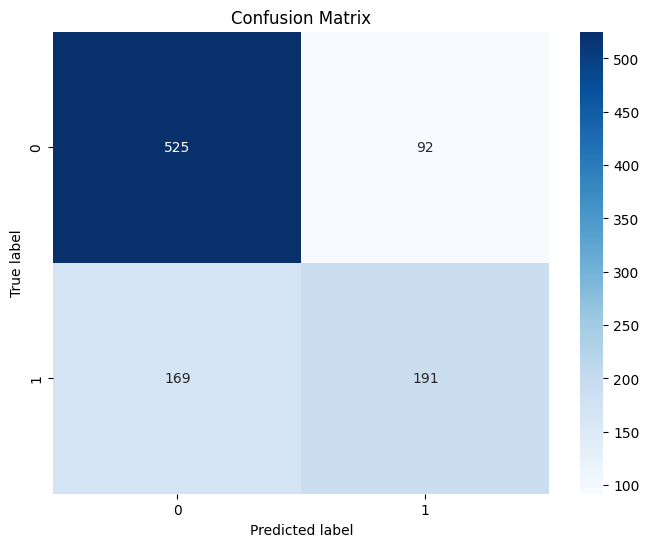

In [ ]:
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
fc_session = FinetuneFC(
              #  train_transform=None,
              #  val_transform=None,
              #  path_for_resuming = 'artifacts/MHIST_FC_run2', # resume from local path if not None (not used for saving best model)
               # resume_from_object = False, # resume from model object
               # model = best_model, # if not resume_from_object, model is initialized to random
               batch_size = 64 if torch.cuda.is_available() else 4,
               eval_on='recall', # for positive (minority) class
               enable_tracking = True,
              #  logger=None,
               )

best_model = fc_session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    learning_rate = 1e-6,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_SmallFC_v1.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST FC (binary classification)",
    #  mlflow_run = None # create a new run
    )


Evaluating the model on recall best_metric = 0.6722222222222223
Initial learning rate 1e-06

Logging metrics with server: http://ec2-3-101-21-63.us-west-1.compute.amazonaws.com:5000
MLflow: run_name = stylish-smelt-204 run_id = caa2912bf26e42929245e8bd374ef4a0
MLflow Experiment name: MHIST FCN (binary classification) 

Device: cuda:0


100%|██████████| 34/34 [00:15<00:00,  2.23it/s]


Epoch 1 train Loss: 0.550, recall: 0.7486136783733827, Accuracy: 0.710
Epoch 1 train: Learning rate changed to 0.000001


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 1 val Loss: 0.582, val_recall: 0.6083333333333333, Accuracy: 0.699
Epoch 0 completed in 0m 21s


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 2 train Loss: 0.313, recall: 0.9126126126126126, Accuracy: 0.908


100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


Epoch 2 val Loss: 0.560, val_recall: 0.5722222222222222, Accuracy: 0.727


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


Epoch 3 train Loss: 0.202, recall: 0.982648401826484, Accuracy: 0.971


100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Epoch 3 val Loss: 0.550, val_recall: 0.5083333333333333, Accuracy: 0.727


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


Epoch 4 train Loss: 0.147, recall: 0.9863138686131386, Accuracy: 0.985


100%|██████████| 16/16 [00:04<00:00,  3.20it/s]


Epoch 4 val Loss: 0.551, val_recall: 0.5222222222222223, Accuracy: 0.734


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 5 train Loss: 0.111, recall: 0.9981600735970562, Accuracy: 0.993
Epoch 5 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 5 val Loss: 0.547, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


Epoch 6 train Loss: 0.093, recall: 0.9981768459434822, Accuracy: 0.995


100%|██████████| 16/16 [00:04<00:00,  3.20it/s]


Epoch 6 val Loss: 0.547, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 7 train Loss: 0.086, recall: 0.9990875912408759, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 7 val Loss: 0.547, val_recall: 0.5333333333333333, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 8 train Loss: 0.086, recall: 0.9981684981684982, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 8 val Loss: 0.548, val_recall: 0.5305555555555556, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 9 train Loss: 0.086, recall: 0.9972451790633609, Accuracy: 0.995


100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Epoch 9 val Loss: 0.548, val_recall: 0.5305555555555556, Accuracy: 0.737


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


Epoch 10 train Loss: 0.080, recall: 0.9981464318813716, Accuracy: 0.998
Epoch 10 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:05<00:00,  3.20it/s]


Epoch 10 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.734


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 11 train Loss: 0.081, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Epoch 11 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.735


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch 12 train Loss: 0.082, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Epoch 12 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.735


100%|██████████| 34/34 [00:15<00:00,  2.24it/s]


Epoch 13 train Loss: 0.080, recall: 1.0, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 13 val Loss: 0.549, val_recall: 0.5305555555555556, Accuracy: 0.736


100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


Epoch 14 train Loss: 0.078, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


Epoch 14 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.736


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 15 train Loss: 0.079, recall: 1.0, Accuracy: 0.998
Epoch 15 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 15 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 16 train Loss: 0.078, recall: 1.0, Accuracy: 1.000


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 16 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 17 train Loss: 0.080, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 17 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch 18 train Loss: 0.079, recall: 1.0, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Epoch 18 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


Epoch 19 train Loss: 0.079, recall: 1.0, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 19 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 20 train Loss: 0.079, recall: 1.0, Accuracy: 0.999
Epoch 20 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 20 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 21 train Loss: 0.079, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


Epoch 21 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:15<00:00,  2.27it/s]


Epoch 22 train Loss: 0.079, recall: 1.0, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Epoch 22 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 23 train Loss: 0.080, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 23 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch 24 train Loss: 0.083, recall: 1.0, Accuracy: 0.999


100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 24 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 25 train Loss: 0.079, recall: 1.0, Accuracy: 0.998
Epoch 25 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Epoch 25 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 26 train Loss: 0.081, recall: 1.0, Accuracy: 0.996


100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 26 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 27 train Loss: 0.079, recall: 1.0, Accuracy: 0.999


100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 27 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


Epoch 28 train Loss: 0.079, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Epoch 28 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


Epoch 29 train Loss: 0.081, recall: 1.0, Accuracy: 0.998


100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 29 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


Epoch 30 train Loss: 0.080, recall: 1.0, Accuracy: 0.999
Epoch 30 train: Learning rate changed to 0.000000


100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 30 val Loss: 0.549, val_recall: 0.5277777777777778, Accuracy: 0.737
Training complete in 10m 20s
Best recall score: 0.6722222222222223
Learning rate: start=1e-06 final=1.0000000000000004e-12
[[530  87]
 [170 190]]
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.80       617
         1.0       0.69      0.53      0.60       360

    accuracy                           0.74       977
   macro avg       0.72      0.69      0.70       977
weighted avg       0.73      0.74      0.73       977



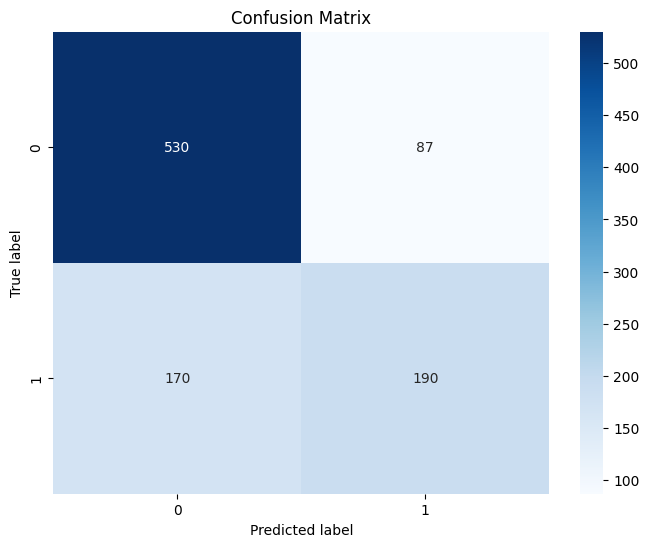

In [ ]:
best_model = fc_session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 30,
    learning_rate = 1e-6,
    best_metric = 0.6722222222222223,
    best_model_dest = "artifacts/MHIST_SmallFC_v2.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST FC (binary classification)",
    #  mlflow_run = None # create a new run
    )


### Train ViT

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new model from timm: vit_base_patch16_224 with pretrained weight tag: augreg2_in21k_ft_in1k
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
---------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.0
Initial learning rate 0.01

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = masked-sheep-165 run_id = 84074e5ab58749f1b609ef5ef90c499f
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 1 (5 steps) train Loss: 0.767, true_positive_rate: 0.7259395050412466, F1: 0.6759759748122999 Accuracy: 0.677


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Improved validation true_positive_rate: 0.8138888888888889
Epoch 1 (5 steps) val Loss: 0.479, val_true_positive_rate: 0.8138888888888889, F1: 0.7813620812667439 Accuracy: 0.778
Epoch 0 completed in 0m 22s


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 2 (10 steps) train Loss: 0.576, true_positive_rate: 0.6382592928377153, F1: 0.7534501177289005 Accuracy: 0.757


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Improved validation true_positive_rate: 0.95
Epoch 2 (10 steps) val Loss: 0.727, val_true_positive_rate: 0.95, F1: 0.6845235472734599 Accuracy: 0.686


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


Epoch 3 (15 steps) train Loss: 0.481, true_positive_rate: 0.9097744360902256, F1: 0.7872931124694622 Accuracy: 0.790


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Improved validation true_positive_rate: 0.625
Epoch 3 (15 steps) val Loss: 0.457, val_true_positive_rate: 0.625, F1: 0.7812174047538881 Accuracy: 0.786


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 4 (20 steps) train Loss: 0.396, true_positive_rate: 0.8240146654445463, F1: 0.8262071169790125 Accuracy: 0.826


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Improved validation true_positive_rate: 0.9
Improved validation weighted_precision: 0.8016439744562481
Saving model weights to artifacts/MHIST_ViT_v13.pt
Epoch 4 (20 steps) val Loss: 0.549, val_true_positive_rate: 0.9, F1: 0.7479091167791236 Accuracy: 0.744


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Epoch 5 (25 steps) train Loss: 0.372, true_positive_rate: 0.8504079782411604, F1: 0.8367332736525536 Accuracy: 0.837
Epoch 5 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Epoch 5 (25 steps) val Loss: 0.428, val_true_positive_rate: 0.775, F1: 0.8069094281047339 Accuracy: 0.806


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 6 (30 steps) train Loss: 0.374, true_positive_rate: 0.812962962962963, F1: 0.8425997384367382 Accuracy: 0.843


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 6 (30 steps) val Loss: 0.448, val_true_positive_rate: 0.825, F1: 0.8042104519435787 Accuracy: 0.801


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Epoch 7 (35 steps) train Loss: 0.337, true_positive_rate: 0.8938547486033519, F1: 0.8582638066374367 Accuracy: 0.858


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 7 (35 steps) val Loss: 0.470, val_true_positive_rate: 0.8611111111111112, F1: 0.7877831995800344 Accuracy: 0.784


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Epoch 8 (40 steps) train Loss: 0.346, true_positive_rate: 0.8992395437262357, F1: 0.8490289259633602 Accuracy: 0.849


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Epoch 8 (40 steps) val Loss: 0.447, val_true_positive_rate: 0.8333333333333334, F1: 0.7974438524170463 Accuracy: 0.794
Training complete in 3m 0s
Best true_positive_rate score: 0.9
Learning rate: start=0.01 final=0.001
[[476 141]
 [ 60 300]]
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83       617
         1.0       0.68      0.83      0.75       360

    accuracy                           0.79       977
   macro avg       0.78      0.80      0.79       977
weighted avg       0.81      0.79      0.80       977



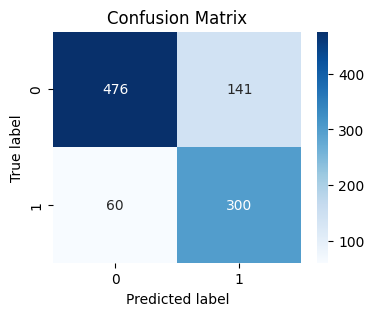

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 (fnr = 0.05)
# Previous best: true_positive_rate = 0.9
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 8,
    # freeze_all_but_head = True,
    learning_rate = 1e-2,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_ViT_v13.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
---------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.8222222222222222
Initial learning rate 0.75

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = able-colt-285 run_id = 657e57eb82854231935ffd516471de6e
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 1 (5 steps) train Loss: 90.990, true_positive_rate: 0.7077922077922078, F1: 0.5370500383273134 Accuracy: 0.549
Epoch 1 train: Learning rate changed to 0.750000


100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


Epoch 1 (5 steps) val Loss: 62.511, val_true_positive_rate: 0.041666666666666664, F1: 0.523019440805402 Accuracy: 0.647
Epoch 0 completed in 0m 22s


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Epoch 2 (10 steps) train Loss: 60.096, true_positive_rate: 0.4100185528756957, F1: 0.6288193860359316 Accuracy: 0.650


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Improved validation true_positive_rate: 0.9777777777777777
Saving model weights to artifacts/MHIST_ViT_v12.pt
Epoch 2 (10 steps) val Loss: 82.933, val_true_positive_rate: 0.9777777777777777, F1: 0.6284160316415576 Accuracy: 0.639


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 3 (15 steps) train Loss: 54.384, true_positive_rate: 0.925, F1: 0.7266527008841007 Accuracy: 0.736


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Epoch 3 (15 steps) val Loss: 28.345, val_true_positive_rate: 0.8333333333333334, F1: 0.7606695250458931 Accuracy: 0.756


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Epoch 4 (20 steps) train Loss: 34.367, true_positive_rate: 0.5949720670391061, F1: 0.7410358153313843 Accuracy: 0.747


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 4 (20 steps) val Loss: 22.874, val_true_positive_rate: 0.6805555555555556, F1: 0.7884834136669387 Accuracy: 0.790


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 5 (25 steps) train Loss: 26.465, true_positive_rate: 0.8539944903581267, F1: 0.7861562653344866 Accuracy: 0.787
Epoch 5 train: Learning rate changed to 0.075000


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 5 (25 steps) val Loss: 35.774, val_true_positive_rate: 0.925, F1: 0.7144387521711988 Accuracy: 0.712


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 6 (30 steps) train Loss: 22.183, true_positive_rate: 0.9379370629370629, F1: 0.8087877930817562 Accuracy: 0.813


100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


Epoch 6 (30 steps) val Loss: 26.710, val_true_positive_rate: 0.8805555555555555, F1: 0.7554136704440083 Accuracy: 0.751


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 7 (35 steps) train Loss: 18.182, true_positive_rate: 0.8779123951537745, F1: 0.807954754330152 Accuracy: 0.809


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Epoch 7 (35 steps) val Loss: 19.200, val_true_positive_rate: 0.7861111111111111, F1: 0.7994279083714919 Accuracy: 0.797


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 8 (40 steps) train Loss: 17.316, true_positive_rate: 0.754337899543379, F1: 0.802330618681854 Accuracy: 0.803


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 8 (40 steps) val Loss: 17.880, val_true_positive_rate: 0.7055555555555556, F1: 0.801277112480177 Accuracy: 0.802


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 9 (45 steps) train Loss: 14.339, true_positive_rate: 0.7406367041198502, F1: 0.8158252626659437 Accuracy: 0.817


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 9 (45 steps) val Loss: 16.984, val_true_positive_rate: 0.7277777777777777, F1: 0.8022827720191767 Accuracy: 0.802


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 10 (50 steps) train Loss: 14.648, true_positive_rate: 0.7860300618921309, F1: 0.8247665583805408 Accuracy: 0.825
Epoch 10 train: Learning rate changed to 0.007500


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Epoch 10 (50 steps) val Loss: 17.431, val_true_positive_rate: 0.8111111111111111, F1: 0.7970660660753943 Accuracy: 0.794


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 11 (55 steps) train Loss: 13.003, true_positive_rate: 0.8597122302158273, F1: 0.8440702402012905 Accuracy: 0.844


100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


Epoch 11 (55 steps) val Loss: 17.479, val_true_positive_rate: 0.8138888888888889, F1: 0.7951533652739822 Accuracy: 0.792


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 12 (60 steps) train Loss: 13.336, true_positive_rate: 0.8504672897196262, F1: 0.8446077539455583 Accuracy: 0.845


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Epoch 12 (60 steps) val Loss: 17.423, val_true_positive_rate: 0.8138888888888889, F1: 0.7941698608648798 Accuracy: 0.791


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 13 (65 steps) train Loss: 10.577, true_positive_rate: 0.8474264705882353, F1: 0.8542464033473982 Accuracy: 0.854


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 13 (65 steps) val Loss: 17.301, val_true_positive_rate: 0.8138888888888889, F1: 0.7961366561474377 Accuracy: 0.793


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 14 (70 steps) train Loss: 11.558, true_positive_rate: 0.8546458141674333, F1: 0.8431985032800674 Accuracy: 0.843


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 14 (70 steps) val Loss: 17.180, val_true_positive_rate: 0.8111111111111111, F1: 0.7970660660753943 Accuracy: 0.794


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 15 (75 steps) train Loss: 12.578, true_positive_rate: 0.8487848784878488, F1: 0.8450558983505619 Accuracy: 0.845
Epoch 15 train: Learning rate changed to 0.000750


100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Epoch 15 (75 steps) val Loss: 17.087, val_true_positive_rate: 0.8083333333333333, F1: 0.7970105319669757 Accuracy: 0.794
Training complete in 5m 29s
Best true_positive_rate score: 0.9777777777777777
Learning rate: start=0.75 final=0.0007500000000000002
[[485 132]
 [ 69 291]]
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       617
         1.0       0.69      0.81      0.74       360

    accuracy                           0.79       977
   macro avg       0.78      0.80      0.79       977
weighted avg       0.81      0.79      0.80       977



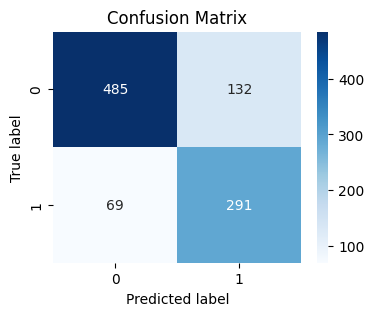

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 15,
    # freeze_all_but_head = True,
    learning_rate = 0.75,
    best_metric = 0.8222222222222222, #true_positive_rate
    best_model_dest = "artifacts/MHIST_ViT_v12.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
---------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.8222222222222222
Initial learning rate 0.1

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = welcoming-hen-596 run_id = b5776f6d01174b0b84c6290097d97ce3
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 5/5 [08:12<00:00, 98.57s/it]


Epoch 1 (5 steps) train Loss: 6.749, true_positive_rate: 0.6053571428571428, F1: 0.6069833293621496 Accuracy: 0.607
Epoch 1 train: Learning rate changed to 0.100000


 50%|█████     | 1/2 [00:03<00:03,  3.67s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 1 (5 steps) val Loss: 3.328, val_true_positive_rate: 0.7972222222222223, F1: 0.7455033623701728 Accuracy: 0.741
Epoch 0 completed in 8m 20s


100%|██████████| 5/5 [03:13<00:00, 38.71s/it]


Epoch 2 (10 steps) train Loss: 4.764, true_positive_rate: 0.8721461187214612, F1: 0.7508815863740153 Accuracy: 0.754


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Improved validation true_positive_rate: 0.8388888888888889
Saving model weights to artifacts/MHIST_ViT_v11.pt
Epoch 2 (10 steps) val Loss: 2.876, val_true_positive_rate: 0.8388888888888889, F1: 0.7486042071759473 Accuracy: 0.744


100%|██████████| 5/5 [01:32<00:00, 18.57s/it]


Epoch 3 (15 steps) train Loss: 3.245, true_positive_rate: 0.6261595547309833, F1: 0.7424272233277807 Accuracy: 0.746


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Improved validation true_positive_rate: 0.8805555555555555
Saving model weights to artifacts/MHIST_ViT_v11.pt
Epoch 3 (15 steps) val Loss: 3.805, val_true_positive_rate: 0.8805555555555555, F1: 0.6991061558352768 Accuracy: 0.696


100%|██████████| 5/5 [00:58<00:00, 11.63s/it]


Epoch 4 (20 steps) train Loss: 2.447, true_positive_rate: 0.8983050847457628, F1: 0.7907361551143315 Accuracy: 0.794


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 4 (20 steps) val Loss: 2.119, val_true_positive_rate: 0.5722222222222222, F1: 0.7807424655098849 Accuracy: 0.790


100%|██████████| 5/5 [00:33<00:00,  6.72s/it]


Epoch 5 (25 steps) train Loss: 1.563, true_positive_rate: 0.7621776504297995, F1: 0.8145041029770094 Accuracy: 0.815
Epoch 5 train: Learning rate changed to 0.010000


100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Improved validation true_positive_rate: 0.9166666666666666
Saving model weights to artifacts/MHIST_ViT_v11.pt
Epoch 5 (25 steps) val Loss: 2.702, val_true_positive_rate: 0.9166666666666666, F1: 0.7317992604897541 Accuracy: 0.729


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


Epoch 6 (30 steps) train Loss: 1.535, true_positive_rate: 0.9047169811320754, F1: 0.8221089755658354 Accuracy: 0.823


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 6 (30 steps) val Loss: 1.853, val_true_positive_rate: 0.8333333333333334, F1: 0.7835869768955572 Accuracy: 0.780


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Epoch 7 (35 steps) train Loss: 1.061, true_positive_rate: 0.832737030411449, F1: 0.8524270212494809 Accuracy: 0.852


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 7 (35 steps) val Loss: 1.552, val_true_positive_rate: 0.75, F1: 0.7973410641357698 Accuracy: 0.796


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


Epoch 8 (40 steps) train Loss: 1.176, true_positive_rate: 0.7938718662952646, F1: 0.8346274100166431 Accuracy: 0.835


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 8 (40 steps) val Loss: 1.498, val_true_positive_rate: 0.7583333333333333, F1: 0.7976268583922919 Accuracy: 0.796


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Epoch 9 (45 steps) train Loss: 0.933, true_positive_rate: 0.8485130111524164, F1: 0.8579106059807838 Accuracy: 0.858


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 9 (45 steps) val Loss: 1.558, val_true_positive_rate: 0.7944444444444444, F1: 0.7849506073336269 Accuracy: 0.782


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 10 (50 steps) train Loss: 0.930, true_positive_rate: 0.8761638733705773, F1: 0.856063356321353 Accuracy: 0.856
Epoch 10 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Epoch 10 (50 steps) val Loss: 1.527, val_true_positive_rate: 0.7916666666666666, F1: 0.784891757756049 Accuracy: 0.782


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Epoch 11 (55 steps) train Loss: 0.934, true_positive_rate: 0.8781630740393627, F1: 0.8565343787527896 Accuracy: 0.857


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Epoch 11 (55 steps) val Loss: 1.509, val_true_positive_rate: 0.7916666666666666, F1: 0.7897891112251065 Accuracy: 0.787


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 12 (60 steps) train Loss: 0.840, true_positive_rate: 0.8789808917197452, F1: 0.860161343972982 Accuracy: 0.860


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 12 (60 steps) val Loss: 1.484, val_true_positive_rate: 0.7888888888888889, F1: 0.7887464437077499 Accuracy: 0.786


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 13 (65 steps) train Loss: 0.715, true_positive_rate: 0.8841911764705882, F1: 0.8698577667922011 Accuracy: 0.870


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 13 (65 steps) val Loss: 1.460, val_true_positive_rate: 0.7777777777777778, F1: 0.7884724161185924 Accuracy: 0.786


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


Epoch 14 (70 steps) train Loss: 0.855, true_positive_rate: 0.8669642857142857, F1: 0.8639116738243112 Accuracy: 0.864


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 14 (70 steps) val Loss: 1.441, val_true_positive_rate: 0.7722222222222223, F1: 0.7922207850639488 Accuracy: 0.790


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 15 (75 steps) train Loss: 0.833, true_positive_rate: 0.8658088235294118, F1: 0.8671262682537607 Accuracy: 0.867
Epoch 15 train: Learning rate changed to 0.000100


100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


Epoch 15 (75 steps) val Loss: 1.433, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 16 (80 steps) train Loss: 0.782, true_positive_rate: 0.8709073900841908, F1: 0.8721857998560242 Accuracy: 0.872


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Epoch 16 (80 steps) val Loss: 1.432, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 17 (85 steps) train Loss: 0.841, true_positive_rate: 0.8562271062271062, F1: 0.8634443501047471 Accuracy: 0.863


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 17 (85 steps) val Loss: 1.431, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 18 (90 steps) train Loss: 0.709, true_positive_rate: 0.8763636363636363, F1: 0.8790841407543665 Accuracy: 0.879


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 18 (90 steps) val Loss: 1.430, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 19 (95 steps) train Loss: 0.701, true_positive_rate: 0.8575445173383318, F1: 0.8716793552129087 Accuracy: 0.872


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Epoch 19 (95 steps) val Loss: 1.430, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Epoch 20 (100 steps) train Loss: 0.832, true_positive_rate: 0.8621646623496763, F1: 0.863447871728715 Accuracy: 0.863
Epoch 20 train: Learning rate changed to 0.000010


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Epoch 20 (100 steps) val Loss: 1.430, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 21 (105 steps) train Loss: 0.830, true_positive_rate: 0.8634237605238541, F1: 0.8620757311538962 Accuracy: 0.862


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 21 (105 steps) val Loss: 1.430, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Epoch 22 (110 steps) train Loss: 0.804, true_positive_rate: 0.8558139534883721, F1: 0.8703041305125767 Accuracy: 0.870


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 22 (110 steps) val Loss: 1.430, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 23 (115 steps) train Loss: 0.818, true_positive_rate: 0.8635097493036211, F1: 0.8625310605461917 Accuracy: 0.863


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Epoch 23 (115 steps) val Loss: 1.430, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 24 (120 steps) train Loss: 0.849, true_positive_rate: 0.8608294930875576, F1: 0.8602300623326273 Accuracy: 0.860


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Epoch 24 (120 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 25 (125 steps) train Loss: 0.752, true_positive_rate: 0.8580470162748643, F1: 0.8662160038397334 Accuracy: 0.866
Epoch 25 train: Learning rate changed to 0.000001


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 25 (125 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 26 (130 steps) train Loss: 0.964, true_positive_rate: 0.8588560885608856, F1: 0.8597698777953741 Accuracy: 0.860


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 26 (130 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 27 (135 steps) train Loss: 0.721, true_positive_rate: 0.8579136690647482, F1: 0.8721952022181068 Accuracy: 0.872


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Epoch 27 (135 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 28 (140 steps) train Loss: 0.767, true_positive_rate: 0.8795620437956204, F1: 0.8749372408932954 Accuracy: 0.875


100%|██████████| 2/2 [00:06<00:00,  3.27s/it]


Epoch 28 (140 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 29 (145 steps) train Loss: 0.815, true_positive_rate: 0.8708260105448155, F1: 0.868988493279622 Accuracy: 0.869


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Epoch 29 (145 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 30 (150 steps) train Loss: 0.776, true_positive_rate: 0.8670886075949367, F1: 0.8703530509586644 Accuracy: 0.870
Epoch 30 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Epoch 30 (150 steps) val Loss: 1.429, val_true_positive_rate: 0.7666666666666667, F1: 0.7910859909310801 Accuracy: 0.789
Training complete in 24m 26s
Best true_positive_rate score: 0.9166666666666666
Learning rate: start=0.1 final=1.0000000000000005e-07
[[495 122]
 [ 84 276]]
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83       617
         1.0       0.69      0.77      0.73       360

    accuracy                           0.79       977
   macro avg       0.77      0.78      0.78       977
weighted avg       0.80      0.79      0.79       977



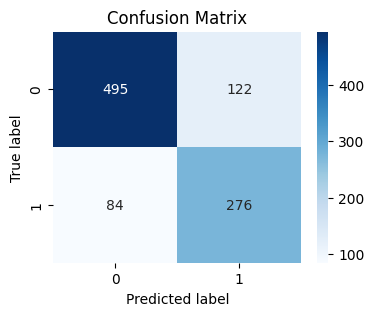

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 30,
    # freeze_all_but_head = True,
    learning_rate = 0.1,
    best_metric = 0.8222222222222222, #true_positive_rate
    best_model_dest = "artifacts/MHIST_ViT_v11.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
---------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.0
Initial learning rate 0.1

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = beautiful-seal-133 run_id = 7d985bc24c4e434d899e41f9803c1021
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 5/5 [09:10<00:00, 110.18s/it]


Epoch 1 (5 steps) train Loss: 8.483, true_positive_rate: 0.5314885496183206, F1: 0.5673503654755851 Accuracy: 0.568
Epoch 1 train: Learning rate changed to 0.100000


 50%|█████     | 1/2 [03:25<03:25, 205.01s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 2/2 [06:34<00:00, 197.38s/it]


Improved validation true_positive_rate: 1.0
Saving model weights to artifacts/MHIST_ViT_v10.pt
Epoch 1 (5 steps) val Loss: 14.316, val_true_positive_rate: 1.0, F1: 0.5202359516992452 Accuracy: 0.557
Epoch 0 completed in 15m 47s


100%|██████████| 5/5 [03:24<00:00, 40.93s/it]


Epoch 2 (10 steps) train Loss: 5.833, true_positive_rate: 0.794010889292196, F1: 0.7350897766782827 Accuracy: 0.736


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 2 (10 steps) val Loss: 4.537, val_true_positive_rate: 0.4527777777777778, F1: 0.7273068279358229 Accuracy: 0.746


100%|██████████| 5/5 [01:31<00:00, 18.35s/it]


Epoch 3 (15 steps) train Loss: 4.392, true_positive_rate: 0.7011070110701108, F1: 0.7622825278950995 Accuracy: 0.763


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 3 (15 steps) val Loss: 6.084, val_true_positive_rate: 0.9361111111111111, F1: 0.6719957412777859 Accuracy: 0.673


100%|██████████| 5/5 [00:55<00:00, 11.05s/it]


Epoch 4 (20 steps) train Loss: 3.029, true_positive_rate: 0.8887876025524157, F1: 0.80596269980554 Accuracy: 0.807


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 4 (20 steps) val Loss: 2.923, val_true_positive_rate: 0.5222222222222223, F1: 0.7616768439930746 Accuracy: 0.775


100%|██████████| 5/5 [00:33<00:00,  6.60s/it]


Epoch 5 (25 steps) train Loss: 2.382, true_positive_rate: 0.7305555555555555, F1: 0.7904532098017218 Accuracy: 0.791
Epoch 5 train: Learning rate changed to 0.010000


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 5 (25 steps) val Loss: 3.455, val_true_positive_rate: 0.9194444444444444, F1: 0.728533874888566 Accuracy: 0.726


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


Epoch 6 (30 steps) train Loss: 2.246, true_positive_rate: 0.9288321167883211, F1: 0.802836370817837 Accuracy: 0.806


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 6 (30 steps) val Loss: 2.465, val_true_positive_rate: 0.8722222222222222, F1: 0.7727382032870564 Accuracy: 0.769


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 7 (35 steps) train Loss: 1.426, true_positive_rate: 0.8835877862595419, F1: 0.8491820133141479 Accuracy: 0.849


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Improved validation weighted_recall: 0.8014329580348004
Improved validation F1-score: 0.8015468070915807
Improved validation accuracy: 0.8014329580348004
Saving model weights to artifacts/MHIST_ViT_v10.pt
Epoch 7 (35 steps) val Loss: 1.870, val_true_positive_rate: 0.7333333333333333, F1: 0.8015468070915807 Accuracy: 0.801


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


Epoch 8 (40 steps) train Loss: 1.637, true_positive_rate: 0.7290145985401459, F1: 0.8129540216387423 Accuracy: 0.814


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Improved validation weighted_recall: 0.8024564994882293
Improved validation accuracy: 0.8024564994882293
Saving model weights to artifacts/MHIST_ViT_v10.pt
Epoch 8 (40 steps) val Loss: 1.842, val_true_positive_rate: 0.7, F1: 0.8010044528794583 Accuracy: 0.802


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


Epoch 9 (45 steps) train Loss: 1.598, true_positive_rate: 0.7823008849557522, F1: 0.826540232254518 Accuracy: 0.827


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Improved validation true_positive_rate: 0.8388888888888889
Improved validation weighted_precision: 0.8226289206799174
Improved validation weighted_recall: 0.8085977482088025
Improved validation F1-score: 0.8113454028066424
Improved validation accuracy: 0.8085977482088025
Saving model weights to artifacts/MHIST_ViT_v10.pt
Epoch 9 (45 steps) val Loss: 1.914, val_true_positive_rate: 0.8388888888888889, F1: 0.8113454028066424 Accuracy: 0.809


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


Epoch 10 (50 steps) train Loss: 1.434, true_positive_rate: 0.8817504655493482, F1: 0.8462990630418957 Accuracy: 0.846
Epoch 10 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Improved validation true_positive_rate: 0.8611111111111112
Saving model weights to artifacts/MHIST_ViT_v10.pt
Epoch 10 (50 steps) val Loss: 1.983, val_true_positive_rate: 0.8611111111111112, F1: 0.8017311773443438 Accuracy: 0.798


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


Epoch 11 (55 steps) train Loss: 1.236, true_positive_rate: 0.8908748824082785, F1: 0.8536947306080601 Accuracy: 0.854


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 11 (55 steps) val Loss: 1.949, val_true_positive_rate: 0.8583333333333333, F1: 0.8026983127559543 Accuracy: 0.799


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Epoch 12 (60 steps) train Loss: 1.183, true_positive_rate: 0.8932038834951457, F1: 0.8566158954680106 Accuracy: 0.857


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 12 (60 steps) val Loss: 1.897, val_true_positive_rate: 0.8527777777777777, F1: 0.8066034171422702 Accuracy: 0.803


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Epoch 13 (65 steps) train Loss: 1.325, true_positive_rate: 0.8847235238987816, F1: 0.8500160566976541 Accuracy: 0.850


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 13 (65 steps) val Loss: 1.840, val_true_positive_rate: 0.8416666666666667, F1: 0.8104034325133415 Accuracy: 0.808


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 14 (70 steps) train Loss: 1.254, true_positive_rate: 0.8779123951537745, F1: 0.8486541975590841 Accuracy: 0.849


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Improved validation weighted_recall: 0.8106448311156602
Improved validation F1-score: 0.8130052252915491
Improved validation accuracy: 0.8106448311156602
Saving model weights to artifacts/MHIST_ViT_v10.pt
Epoch 14 (70 steps) val Loss: 1.786, val_true_positive_rate: 0.8222222222222222, F1: 0.8130052252915491 Accuracy: 0.811


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Epoch 15 (75 steps) train Loss: 1.230, true_positive_rate: 0.8551787351054079, F1: 0.8556324890867043 Accuracy: 0.856
Epoch 15 train: Learning rate changed to 0.000100


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Epoch 15 (75 steps) val Loss: 1.750, val_true_positive_rate: 0.8055555555555556, F1: 0.8096935675684073 Accuracy: 0.808


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 16 (80 steps) train Loss: 1.261, true_positive_rate: 0.8510258697591436, F1: 0.8492070789655987 Accuracy: 0.849


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Epoch 16 (80 steps) val Loss: 1.747, val_true_positive_rate: 0.8055555555555556, F1: 0.8096935675684073 Accuracy: 0.808


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 17 (85 steps) train Loss: 1.136, true_positive_rate: 0.8709090909090909, F1: 0.8574312914100966 Accuracy: 0.857


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 17 (85 steps) val Loss: 1.745, val_true_positive_rate: 0.8027777777777778, F1: 0.8096265895357804 Accuracy: 0.808


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Epoch 18 (90 steps) train Loss: 1.217, true_positive_rate: 0.8505106778087279, F1: 0.8510356794549689 Accuracy: 0.851


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 18 (90 steps) val Loss: 1.743, val_true_positive_rate: 0.8, F1: 0.8085796198834512 Accuracy: 0.807


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Epoch 19 (95 steps) train Loss: 1.141, true_positive_rate: 0.846012832263978, F1: 0.848735632183908 Accuracy: 0.849


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 19 (95 steps) val Loss: 1.741, val_true_positive_rate: 0.8, F1: 0.8085796198834512 Accuracy: 0.807


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 20 (100 steps) train Loss: 1.022, true_positive_rate: 0.8759057971014492, F1: 0.8717189843084954 Accuracy: 0.872
Epoch 20 train: Learning rate changed to 0.000010


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Epoch 20 (100 steps) val Loss: 1.739, val_true_positive_rate: 0.8, F1: 0.8085796198834512 Accuracy: 0.807
Training complete in 28m 34s
Best true_positive_rate score: 0.8222222222222222
Learning rate: start=0.1 final=1.0000000000000004e-05
[[500 117]
 [ 72 288]]
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       617
         1.0       0.71      0.80      0.75       360

    accuracy                           0.81       977
   macro avg       0.79      0.81      0.80       977
weighted avg       0.81      0.81      0.81       977



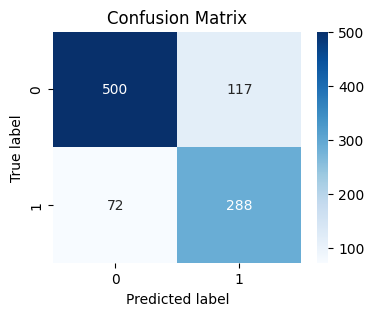

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 20,
    # freeze_all_but_head = True,
    learning_rate = 0.1,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_ViT_v10.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.0
Initial learning rate 0.1

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = rumbling-conch-769 run_id = 7848853a2c0c467499d21c64d840750e
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


Epoch 1 train Loss: 6.819, true_positive_rate: 0.6714801444043321, Accuracy: 0.625
Epoch 1 train: Learning rate changed to 0.100000


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation true_positive_rate: 0.9694444444444444
Saving model weights to artifacts/MHIST_ViT_v9.pt
Epoch 1 val Loss: 8.520, val_true_positive_rate: 0.9694444444444444, Accuracy: 0.625
Epoch 0 completed in 0m 24s


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Epoch 2 train Loss: 5.329, true_positive_rate: 0.6517857142857143, Accuracy: 0.726


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 2 val Loss: 2.850, val_true_positive_rate: 0.825, Accuracy: 0.758


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Epoch 3 train Loss: 3.472, true_positive_rate: 0.9042844120328167, Accuracy: 0.777


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 3 val Loss: 2.372, val_true_positive_rate: 0.6944444444444444, Accuracy: 0.779


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


Epoch 4 train Loss: 2.251, true_positive_rate: 0.6730945821854912, Accuracy: 0.774


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 4 val Loss: 2.980, val_true_positive_rate: 0.9083333333333333, Accuracy: 0.730


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 5 train Loss: 1.696, true_positive_rate: 0.884765625, Accuracy: 0.819
Epoch 5 train: Learning rate changed to 0.010000


100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


Improved validation weighted_recall: 0.8004094165813715
Improved validation accuracy: 0.8004094165813715
Saving model weights to artifacts/MHIST_ViT_v9.pt
Epoch 5 val Loss: 1.882, val_true_positive_rate: 0.6166666666666667, Accuracy: 0.800


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Epoch 6 train Loss: 1.645, true_positive_rate: 0.6419868791002812, Accuracy: 0.794


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Improved validation true_positive_rate: 0.7472222222222222
Saving model weights to artifacts/MHIST_ViT_v9.pt
Epoch 6 val Loss: 1.619, val_true_positive_rate: 0.7472222222222222, Accuracy: 0.790


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


Epoch 7 train Loss: 1.074, true_positive_rate: 0.8728737690241719, Accuracy: 0.840


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


Improved validation true_positive_rate: 0.8888888888888888
Saving model weights to artifacts/MHIST_ViT_v9.pt
Epoch 7 val Loss: 2.163, val_true_positive_rate: 0.8888888888888888, Accuracy: 0.742


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Epoch 8 train Loss: 1.076, true_positive_rate: 0.9377901578458682, Accuracy: 0.842


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 8 val Loss: 1.708, val_true_positive_rate: 0.8416666666666667, Accuracy: 0.772


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 9 train Loss: 1.004, true_positive_rate: 0.8586046511627907, Accuracy: 0.851


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 9 val Loss: 1.378, val_true_positive_rate: 0.7055555555555556, Accuracy: 0.794


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 10 train Loss: 1.012, true_positive_rate: 0.7784810126582279, Accuracy: 0.833
Epoch 10 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Improved validation F1-score: 0.7948908773043621
Saving model weights to artifacts/MHIST_ViT_v9.pt
Epoch 10 val Loss: 1.318, val_true_positive_rate: 0.7361111111111112, Accuracy: 0.794
Training complete in 3m 51s
Best true_positive_rate score: 0.7361111111111112
Learning rate: start=0.1 final=0.0010000000000000002
[[511 106]
 [ 95 265]]
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84       617
         1.0       0.71      0.74      0.73       360

    accuracy                           0.79       977
   macro avg       0.78      0.78      0.78       977
weighted avg       0.80      0.79      0.79       977



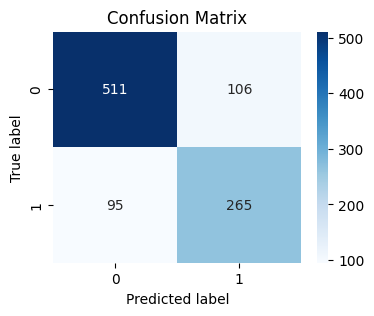

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    # freeze_all_but_head = True,
    learning_rate = 0.1,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_ViT_v9.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.0
Initial learning rate 0.01

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = handsome-horse-660 run_id = 1f04c2d7e37841c992343130ad51217d
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 5/5 [05:08<00:00, 61.62s/it]


Epoch 1 train Loss: 0.706, true_positive_rate: 0.732484076433121, Accuracy: 0.669
Epoch 1 train: Learning rate changed to 0.010000


 50%|█████     | 1/2 [01:54<01:54, 114.03s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 2/2 [03:37<00:00, 108.65s/it]


Improved validation true_positive_rate: 0.4666666666666667
Saving model weights to artifacts/MHIST_ViT_v8.pt
Epoch 1 val Loss: 0.543, val_true_positive_rate: 0.4666666666666667, Accuracy: 0.753
Epoch 0 completed in 8m 46s


100%|██████████| 5/5 [01:57<00:00, 23.53s/it]


Epoch 2 train Loss: 0.625, true_positive_rate: 0.6757741347905283, Accuracy: 0.745


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Improved validation true_positive_rate: 0.9638888888888889
Saving model weights to artifacts/MHIST_ViT_v8.pt
Epoch 2 val Loss: 0.803, val_true_positive_rate: 0.9638888888888889, Accuracy: 0.680


100%|██████████| 5/5 [01:02<00:00, 12.44s/it]


Epoch 3 train Loss: 0.486, true_positive_rate: 0.8099547511312217, Accuracy: 0.788


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Improved validation weighted_recall: 0.7963152507676561
Improved validation accuracy: 0.7963152507676561
Saving model weights to artifacts/MHIST_ViT_v8.pt
Epoch 3 val Loss: 0.452, val_true_positive_rate: 0.6777777777777778, Accuracy: 0.796


100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


Epoch 4 train Loss: 0.411, true_positive_rate: 0.8536812674743709, Accuracy: 0.820


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Improved validation true_positive_rate: 0.8694444444444445
Saving model weights to artifacts/MHIST_ViT_v8.pt
Epoch 4 val Loss: 0.503, val_true_positive_rate: 0.8694444444444445, Accuracy: 0.774


100%|██████████| 5/5 [00:27<00:00,  5.42s/it]


Epoch 5 train Loss: 0.377, true_positive_rate: 0.8018867924528302, Accuracy: 0.831
Epoch 5 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 5 val Loss: 0.450, val_true_positive_rate: 0.7833333333333333, Accuracy: 0.785


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Epoch 6 train Loss: 0.369, true_positive_rate: 0.8192552225249773, Accuracy: 0.837


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 6 val Loss: 0.462, val_true_positive_rate: 0.8166666666666667, Accuracy: 0.784


100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


Epoch 7 train Loss: 0.321, true_positive_rate: 0.8703358208955224, Accuracy: 0.862


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Improved validation weighted_precision: 0.81303588853412
Saving model weights to artifacts/MHIST_ViT_v8.pt
Epoch 7 val Loss: 0.483, val_true_positive_rate: 0.8638888888888889, Accuracy: 0.785


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Epoch 8 train Loss: 0.339, true_positive_rate: 0.8796046720575023, Accuracy: 0.847


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 8 val Loss: 0.476, val_true_positive_rate: 0.8555555555555555, Accuracy: 0.785
Training complete in 14m 36s
Best true_positive_rate score: 0.8638888888888889
Learning rate: start=0.01 final=0.001
[[459 158]
 [ 52 308]]
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81       617
         1.0       0.66      0.86      0.75       360

    accuracy                           0.79       977
   macro avg       0.78      0.80      0.78       977
weighted avg       0.81      0.79      0.79       977



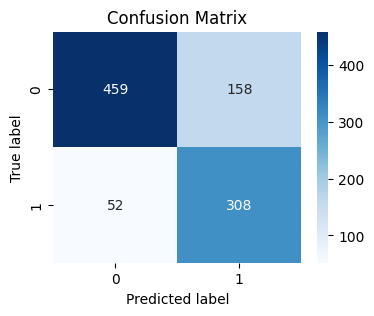

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 8,
    # freeze_all_but_head = True,
    learning_rate = 1e-2,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_ViT_v8.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )


Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.8444444444444444
Initial learning rate 0.05

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = delicate-worm-644 run_id = 93db8d727cb0405b9775306ce01ca341
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 1 train Loss: 4.033, true_positive_rate: 0.6012433392539964, Accuracy: 0.613
Epoch 1 train: Learning rate changed to 0.050000


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Improved validation true_positive_rate: 1.0
Saving model weights to artifacts/MHIST_ViT_v7.pt
Epoch 1 val Loss: 8.092, val_true_positive_rate: 1.0, Accuracy: 0.538
Epoch 0 completed in 0m 23s


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 2 train Loss: 3.513, true_positive_rate: 0.7956600361663653, Accuracy: 0.723


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 2 val Loss: 1.953, val_true_positive_rate: 0.44722222222222224, Accuracy: 0.757


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 3 train Loss: 2.118, true_positive_rate: 0.728110599078341, Accuracy: 0.759


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 3 val Loss: 2.484, val_true_positive_rate: 0.925, Accuracy: 0.689


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 4 train Loss: 1.474, true_positive_rate: 0.7532347504621072, Accuracy: 0.769


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 4 val Loss: 1.144, val_true_positive_rate: 0.6138888888888889, Accuracy: 0.776


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


Epoch 5 train Loss: 0.901, true_positive_rate: 0.8526413345690455, Accuracy: 0.810
Epoch 5 train: Learning rate changed to 0.005000


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 5 val Loss: 1.265, val_true_positive_rate: 0.8777777777777778, Accuracy: 0.770


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 6 train Loss: 0.785, true_positive_rate: 0.8654750705550329, Accuracy: 0.841


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 6 val Loss: 1.054, val_true_positive_rate: 0.8166666666666667, Accuracy: 0.782


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 7 train Loss: 0.708, true_positive_rate: 0.8183556405353728, Accuracy: 0.832


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 7 val Loss: 0.936, val_true_positive_rate: 0.7527777777777778, Accuracy: 0.787


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 8 train Loss: 0.718, true_positive_rate: 0.7958115183246073, Accuracy: 0.832


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 8 val Loss: 0.936, val_true_positive_rate: 0.7805555555555556, Accuracy: 0.786


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 9 train Loss: 0.636, true_positive_rate: 0.8516187050359713, Accuracy: 0.855


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 9 val Loss: 1.011, val_true_positive_rate: 0.8277777777777777, Accuracy: 0.772


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 10 train Loss: 0.589, true_positive_rate: 0.9103260869565217, Accuracy: 0.854
Epoch 10 train: Learning rate changed to 0.000500


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 10 val Loss: 0.930, val_true_positive_rate: 0.8, Accuracy: 0.777
Training complete in 3m 48s
Best true_positive_rate score: 1.0
Learning rate: start=0.05 final=0.0005000000000000001
[[471 146]
 [ 72 288]]
              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       617
         1.0       0.66      0.80      0.73       360

    accuracy                           0.78       977
   macro avg       0.77      0.78      0.77       977
weighted avg       0.79      0.78      0.78       977



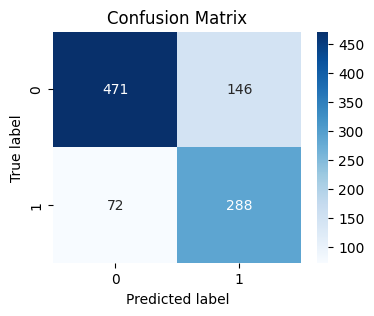

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    # freeze_all_but_head = True,
    learning_rate = 0.05,
    best_metric = 0.8444444444444444,
    best_model_dest = "artifacts/MHIST_ViT_v7.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.0
Initial learning rate 0.01

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = stately-colt-33 run_id = c325a2e952a342bf8f686150221973ba
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 1 train Loss: 0.965, true_positive_rate: 0.6617781851512374, Accuracy: 0.622
Epoch 1 train: Learning rate changed to 0.010000


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Improved validation true_positive_rate: 0.9777777777777777
Improved validation weighted_precision: 0.7884201970696091
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 1 val Loss: 1.165, val_true_positive_rate: 0.9777777777777777, Accuracy: 0.604
Epoch 0 completed in 0m 24s


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


Epoch 2 train Loss: 0.680, true_positive_rate: 0.7263544536271809, Accuracy: 0.740


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation weighted_recall: 0.7901740020470829
Improved validation F1-score: 0.7866965068013886
Improved validation accuracy: 0.7901740020470829
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 2 val Loss: 0.491, val_true_positive_rate: 0.65, Accuracy: 0.790


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


Epoch 3 train Loss: 0.551, true_positive_rate: 0.8328958880139983, Accuracy: 0.770


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Improved validation true_positive_rate: 0.8722222222222222
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 3 val Loss: 0.709, val_true_positive_rate: 0.8722222222222222, Accuracy: 0.692


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Epoch 4 train Loss: 0.485, true_positive_rate: 0.7945334590009425, Accuracy: 0.803


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation weighted_precision: 0.7895963160109724
Improved validation F1-score: 0.7898637224314237
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 4 val Loss: 0.463, val_true_positive_rate: 0.7083333333333334, Accuracy: 0.790


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Epoch 5 train Loss: 0.432, true_positive_rate: 0.8458748866727108, Accuracy: 0.808
Epoch 5 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation true_positive_rate: 0.9222222222222223
Improved validation weighted_precision: 0.7974288875005354
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 5 val Loss: 0.624, val_true_positive_rate: 0.9222222222222223, Accuracy: 0.716


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 6 train Loss: 0.390, true_positive_rate: 0.9128014842300557, Accuracy: 0.820


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation weighted_precision: 0.8122860371602683
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 6 val Loss: 0.533, val_true_positive_rate: 0.9055555555555556, Accuracy: 0.760


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Epoch 7 train Loss: 0.352, true_positive_rate: 0.8910714285714286, Accuracy: 0.847


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Improved validation weighted_precision: 0.8173664497278982
Improved validation weighted_recall: 0.7963152507676561
Improved validation F1-score: 0.799664204281914
Improved validation accuracy: 0.7963152507676561
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 7 val Loss: 0.457, val_true_positive_rate: 0.8527777777777777, Accuracy: 0.796


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


Epoch 8 train Loss: 0.348, true_positive_rate: 0.839458413926499, Accuracy: 0.845


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Improved validation weighted_recall: 0.8065506653019447
Improved validation F1-score: 0.8087789235062482
Improved validation accuracy: 0.8065506653019447
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 8 val Loss: 0.430, val_true_positive_rate: 0.8083333333333333, Accuracy: 0.807


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Epoch 9 train Loss: 0.353, true_positive_rate: 0.8092165898617512, Accuracy: 0.836


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Improved validation true_positive_rate: 0.8138888888888889
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 9 val Loss: 0.433, val_true_positive_rate: 0.8138888888888889, Accuracy: 0.800


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 10 train Loss: 0.329, true_positive_rate: 0.8441441441441442, Accuracy: 0.852
Epoch 10 train: Learning rate changed to 0.000100


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation true_positive_rate: 0.8444444444444444
Saving model weights to artifacts/MHIST_ViT_v6.pt
Epoch 10 val Loss: 0.459, val_true_positive_rate: 0.8444444444444444, Accuracy: 0.791
Training complete in 4m 4s
Best true_positive_rate score: 0.8444444444444444
Learning rate: start=0.01 final=0.0001
[[469 148]
 [ 56 304]]
              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       617
         1.0       0.67      0.84      0.75       360

    accuracy                           0.79       977
   macro avg       0.78      0.80      0.79       977
weighted avg       0.81      0.79      0.79       977



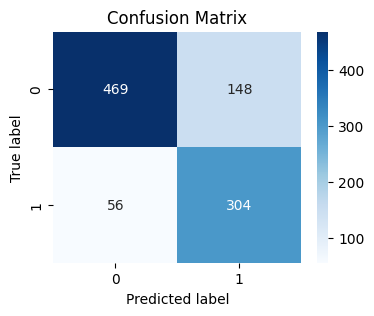

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    # freeze_all_but_head = True,
    learning_rate = 1e-2,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_ViT_v6.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 5 batches, validating with 2 batches with batch_size 512
train_num_batches 5 and val_num_batches 2
Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on true_positive_rate best_metric = 0.0
Initial learning rate 0.001

Logging metrics with server: http://13.52.243.246:5000
MLflow: run_name = sassy-croc-965 run_id = 92e50c15aedf4dc594bea09620a85bfa
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Epoch 1 train Loss: 0.728, true_positive_rate: 0.5685372585096596, Accuracy: 0.526
Epoch 1 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Improved validation true_positive_rate: 0.7888888888888889
Improved validation weighted_precision: 0.7240524371678067
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 1 val Loss: 0.600, val_true_positive_rate: 0.7888888888888889, Accuracy: 0.675
Epoch 0 completed in 0m 24s


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Epoch 2 train Loss: 0.558, true_positive_rate: 0.7388059701492538, Accuracy: 0.700


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation true_positive_rate: 0.8472222222222222
Improved validation weighted_precision: 0.7699037283399024
Improved validation weighted_recall: 0.7205731832139202
Improved validation F1-score: 0.7251004216378023
Improved validation accuracy: 0.7205731832139202
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 2 val Loss: 0.532, val_true_positive_rate: 0.8472222222222222, Accuracy: 0.721


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Epoch 3 train Loss: 0.514, true_positive_rate: 0.7421665174574754, Accuracy: 0.739


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Improved validation true_positive_rate: 0.8777777777777778
Improved validation weighted_precision: 0.778155485469612
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 3 val Loss: 0.539, val_true_positive_rate: 0.8777777777777778, Accuracy: 0.715


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Epoch 4 train Loss: 0.481, true_positive_rate: 0.8381818181818181, Accuracy: 0.762


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Improved validation true_positive_rate: 0.8944444444444445
Improved validation weighted_precision: 0.7812284017639521
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 4 val Loss: 0.547, val_true_positive_rate: 0.8944444444444445, Accuracy: 0.708


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 5 train Loss: 0.431, true_positive_rate: 0.8285449490268767, Accuracy: 0.785
Epoch 5 train: Learning rate changed to 0.000100


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Improved validation weighted_precision: 0.7831439941363533
Improved validation weighted_recall: 0.7420675537359263
Improved validation F1-score: 0.7465241846881956
Improved validation accuracy: 0.7420675537359263
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 5 val Loss: 0.485, val_true_positive_rate: 0.85, Accuracy: 0.742


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 6 train Loss: 0.453, true_positive_rate: 0.7914338919925512, Accuracy: 0.774


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Improved validation weighted_precision: 0.7855383248681949
Improved validation weighted_recall: 0.7461617195496417
Improved validation F1-score: 0.7505810374291717
Improved validation accuracy: 0.7461617195496417
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 6 val Loss: 0.483, val_true_positive_rate: 0.85, Accuracy: 0.746


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Epoch 7 train Loss: 0.440, true_positive_rate: 0.8113553113553114, Accuracy: 0.778


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Improved validation weighted_precision: 0.7867424851623562
Improved validation weighted_recall: 0.7482088024564995
Improved validation F1-score: 0.7526059268227681
Improved validation accuracy: 0.7482088024564995
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 7 val Loss: 0.481, val_true_positive_rate: 0.85, Accuracy: 0.748


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Epoch 8 train Loss: 0.432, true_positive_rate: 0.8179297597042514, Accuracy: 0.794


100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Improved validation true_positive_rate: 0.8527777777777777
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 8 val Loss: 0.485, val_true_positive_rate: 0.8527777777777777, Accuracy: 0.743


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Epoch 9 train Loss: 0.438, true_positive_rate: 0.8174603174603174, Accuracy: 0.786


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Improved validation true_positive_rate: 0.8666666666666667
Improved validation weighted_precision: 0.7879946532418702
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 9 val Loss: 0.492, val_true_positive_rate: 0.8666666666666667, Accuracy: 0.741


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Epoch 10 train Loss: 0.437, true_positive_rate: 0.820855614973262, Accuracy: 0.781
Epoch 10 train: Learning rate changed to 0.000010


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Improved validation true_positive_rate: 0.875
Improved validation weighted_precision: 0.7880607070538979
Saving model weights to artifacts/MHIST_ViT_v5.pt
Epoch 10 val Loss: 0.501, val_true_positive_rate: 0.875, Accuracy: 0.736
Training complete in 4m 6s
Best true_positive_rate score: 0.875
Learning rate: start=0.001 final=1e-05
[[404 213]
 [ 45 315]]
              precision    recall  f1-score   support

         0.0       0.90      0.65      0.76       617
         1.0       0.60      0.88      0.71       360

    accuracy                           0.74       977
   macro avg       0.75      0.76      0.73       977
weighted avg       0.79      0.74      0.74       977



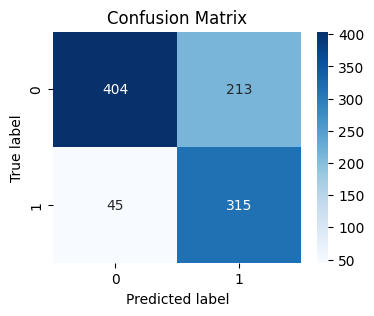

In [ ]:
# Eval on: improved true_positive_rate, ideally > 0.95 # fnr = 0.05
# previous best: eval_on f1 , best_metric=0.7669682977041087
# Improved validation recall: 0.5482954545454546
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    # path_for_resuming = 'artifacts/MHIST_FCN_run2', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = best_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 512,
    eval_on='true_positive_rate', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    # freeze_all_but_head = True,
    learning_rate = 1e-3,
    best_metric = 0.,
    best_model_dest = "artifacts/MHIST_ViT_v5.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 3 batches, validating with 2 batches with batch_size 960
train_num_batches 3 and val_num_batches 2
Info: Resuming from saved state dict artifacts/MHIST_ViT_v1.pt


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on f1 best_metric = 0.5200058467290875
Initial learning rate 1e-10

Logging metrics with server: http://ec2-3-101-21-63.us-west-1.compute.amazonaws.com:5000
MLflow: run_name = vaunted-boar-900 run_id = 5dcdb00122574fe4ae1d1673c0d44768
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 3/3 [16:38<00:00, 332.72s/it]


Epoch 1 train Loss: 0.634, f1: 0.6243444388744229, Accuracy: 0.650
Epoch 1 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [12:39<00:00, 379.74s/it]


Epoch 1 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553
Epoch 0 completed in 29m 18s


100%|██████████| 3/3 [06:58<00:00, 139.45s/it]


Epoch 2 train Loss: 0.620, f1: 0.6221132279578148, Accuracy: 0.649


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Epoch 2 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [02:56<00:00, 58.73s/it]


Epoch 3 train Loss: 0.618, f1: 0.6353967411898445, Accuracy: 0.661


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Epoch 3 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [01:24<00:00, 28.05s/it]


Epoch 4 train Loss: 0.604, f1: 0.6388763954557688, Accuracy: 0.666


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Epoch 4 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:55<00:00, 18.61s/it]


Epoch 5 train Loss: 0.601, f1: 0.6313090651370041, Accuracy: 0.661
Epoch 5 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Epoch 5 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:40<00:00, 13.55s/it]


Epoch 6 train Loss: 0.609, f1: 0.6312200839728904, Accuracy: 0.660


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Epoch 6 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:28<00:00,  9.49s/it]


Epoch 7 train Loss: 0.620, f1: 0.6324165000768098, Accuracy: 0.658


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Epoch 7 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:27<00:00,  9.18s/it]


Epoch 8 train Loss: 0.619, f1: 0.6266037810990562, Accuracy: 0.654


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Epoch 8 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:22<00:00,  7.52s/it]


Epoch 9 train Loss: 0.607, f1: 0.6351084918480598, Accuracy: 0.663


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Epoch 9 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


Epoch 10 train Loss: 0.616, f1: 0.6172066004416873, Accuracy: 0.646
Epoch 10 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch 10 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.98s/it]


Epoch 11 train Loss: 0.617, f1: 0.6280730921000738, Accuracy: 0.656


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Epoch 11 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.95s/it]


Epoch 12 train Loss: 0.616, f1: 0.6229815102328864, Accuracy: 0.648


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Epoch 12 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.04s/it]


Epoch 13 train Loss: 0.631, f1: 0.6082958038303115, Accuracy: 0.637


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch 13 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.18s/it]


Epoch 14 train Loss: 0.631, f1: 0.6185391936232899, Accuracy: 0.645


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch 14 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.94s/it]


Epoch 15 train Loss: 0.622, f1: 0.6266845956575394, Accuracy: 0.655
Epoch 15 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Epoch 15 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553
Training complete in 48m 4s
Best f1 score: 0.5200058467290875
Learning rate: start=1e-10 final=1.0000000000000003e-13
[[189 428]
 [  9 351]]
              precision    recall  f1-score   support

         0.0       0.95      0.31      0.46       617
         1.0       0.45      0.97      0.62       360

    accuracy                           0.55       977
   macro avg       0.70      0.64      0.54       977
weighted avg       0.77      0.55      0.52       977



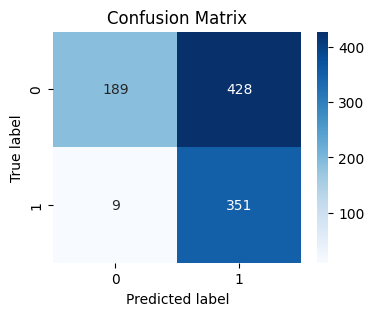

In [ ]:
# previous best: eval_on f1=0.7669682977041087
# previous best: eval_on recall=0.975 f1=0.5200058467290875
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    path_for_resuming = 'artifacts/MHIST_ViT_v1.pt', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = another_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 960, # 512 if torch.cuda.is_available() else 4,
    eval_on='f1', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 15,
    # freeze_all_but_head = True,
    learning_rate = 1e-10, # too low! but it improved recall
    best_metric = 0.5200058467290875,
    best_model_dest = "artifacts/MHIST_ViT_v3.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

In [ ]:
!nvidia-smi # 10.2 GB

Wed Jun 26 12:33:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   73C    P0              33W /  72W |  10245MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on f1 best_metric = 0.5200058467290875
Initial learning rate 1e-08

Logging metrics with server: http://ec2-3-101-21-63.us-west-1.compute.amazonaws.com:5000
MLflow: run_name = orderly-whale-231 run_id = 913ab9f5c68e4f56af4c89fcd8af6fb9
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 3/3 [00:21<00:00,  7.15s/it]


Epoch 1 train Loss: 0.629, f1: 0.6102469311694213, Accuracy: 0.641
Epoch 1 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Epoch 1 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553
Epoch 0 completed in 0m 32s


100%|██████████| 3/3 [00:21<00:00,  7.04s/it]


Epoch 2 train Loss: 0.625, f1: 0.6259387667925996, Accuracy: 0.656


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch 2 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.94s/it]


Epoch 3 train Loss: 0.632, f1: 0.618496371438029, Accuracy: 0.647


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch 3 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.18s/it]


Epoch 4 train Loss: 0.618, f1: 0.6398000950032284, Accuracy: 0.662


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


Epoch 4 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.96s/it]


Epoch 5 train Loss: 0.624, f1: 0.6342985443266278, Accuracy: 0.662
Epoch 5 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch 5 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.01s/it]


Epoch 6 train Loss: 0.633, f1: 0.615167311055346, Accuracy: 0.643


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Epoch 6 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.00s/it]


Epoch 7 train Loss: 0.619, f1: 0.6243535195783969, Accuracy: 0.651


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Epoch 7 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.98s/it]


Epoch 8 train Loss: 0.606, f1: 0.6404241755626243, Accuracy: 0.669


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Epoch 8 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.01s/it]


Epoch 9 train Loss: 0.615, f1: 0.6326029240566942, Accuracy: 0.661


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Epoch 9 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.93s/it]


Epoch 10 train Loss: 0.604, f1: 0.644558243372314, Accuracy: 0.668
Epoch 10 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Epoch 10 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  7.00s/it]


Epoch 11 train Loss: 0.608, f1: 0.6438213671193831, Accuracy: 0.666


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch 11 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.03s/it]


Epoch 12 train Loss: 0.615, f1: 0.6239765229521294, Accuracy: 0.655


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch 12 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.94s/it]


Epoch 13 train Loss: 0.634, f1: 0.6189708842830931, Accuracy: 0.647


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Epoch 13 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:21<00:00,  7.02s/it]


Epoch 14 train Loss: 0.630, f1: 0.6106716464497056, Accuracy: 0.642


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Epoch 14 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553


100%|██████████| 3/3 [00:20<00:00,  6.98s/it]


Epoch 15 train Loss: 0.606, f1: 0.6400078276090729, Accuracy: 0.669
Epoch 15 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Epoch 15 val Loss: 0.749, val_f1: 0.5200058467290875, Accuracy: 0.553
Training complete in 7m 49s
Best f1 score: 0.5200058467290875
Learning rate: start=1e-10 final=1.0000000000000003e-11
[[189 428]
 [  9 351]]
              precision    recall  f1-score   support

         0.0       0.95      0.31      0.46       617
         1.0       0.45      0.97      0.62       360

    accuracy                           0.55       977
   macro avg       0.70      0.64      0.54       977
weighted avg       0.77      0.55      0.52       977



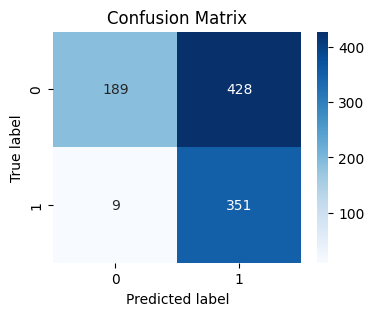

In [ ]:
# previous best: eval_on f1=0.7669682977041087
# previous best: eval_on recall=0.975 f1=0.5200058467290875

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 15,
    # freeze_all_but_head = True,
    learning_rate = 1e-8,
    best_metric = 0.5200058467290875, # continue training on f1
    best_model_dest = "artifacts/MHIST_ViT_v4.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

In [ ]:
!nvidia-smi

Setting up data:
Using ViT transforms
train_df len 2175 test_df len 977
Training with 3 batches, validating with 2 batches with batch_size 960
train_num_batches 3 and val_num_batches 2
Info: Resuming from saved state dict artifacts/MHIST_ViT_v1.pt


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Allocating a new vit_base_patch16_224
Loading a copy of initial model weights into memory
Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on recall best_metric = 0.975
Initial learning rate 1e-05

Logging metrics with server: http://ec2-3-101-21-63.us-west-1.compute.amazonaws.com:5000
MLflow: run_name = ambitious-bug-85 run_id = 4f3b18f7ddb743c3935810cf94f9f5dc
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0 torch.cuda.device_count: 1


100%|██████████| 3/3 [16:51<00:00, 337.17s/it]


Epoch 1 train Loss: 0.617, recall: 0.9185119574844995, Accuracy: 0.667
Epoch 1 train: Learning rate changed to 0.000010


100%|██████████| 2/2 [12:42<00:00, 381.02s/it]


Epoch 1 val Loss: 0.744, val_recall: 0.975, Accuracy: 0.559
Epoch 0 completed in 29m 34s


100%|██████████| 3/3 [06:12<00:00, 124.20s/it]


Epoch 2 train Loss: 0.619, recall: 0.929368029739777, Accuracy: 0.657


100%|██████████| 2/2 [00:09<00:00,  4.83s/it]


Epoch 2 val Loss: 0.739, val_recall: 0.975, Accuracy: 0.562


100%|██████████| 3/3 [03:22<00:00, 67.65s/it]


Epoch 3 train Loss: 0.611, recall: 0.928505957836847, Accuracy: 0.666


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Epoch 3 val Loss: 0.735, val_recall: 0.975, Accuracy: 0.563


100%|██████████| 3/3 [01:23<00:00, 27.68s/it]


Epoch 4 train Loss: 0.591, recall: 0.9054415700267618, Accuracy: 0.675


100%|██████████| 2/2 [00:09<00:00,  4.83s/it]


Epoch 4 val Loss: 0.730, val_recall: 0.9638888888888889, Accuracy: 0.562


100%|██████████| 3/3 [01:07<00:00, 22.59s/it]


Epoch 5 train Loss: 0.610, recall: 0.9196597353497165, Accuracy: 0.657
Epoch 5 train: Learning rate changed to 0.000001


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Epoch 5 val Loss: 0.726, val_recall: 0.9555555555555556, Accuracy: 0.563


100%|██████████| 3/3 [00:45<00:00, 15.21s/it]


Epoch 6 train Loss: 0.608, recall: 0.9195298372513563, Accuracy: 0.665


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Epoch 6 val Loss: 0.725, val_recall: 0.9555555555555556, Accuracy: 0.563


100%|██████████| 3/3 [00:34<00:00, 11.40s/it]


Epoch 7 train Loss: 0.625, recall: 0.9046728971962616, Accuracy: 0.648


100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Epoch 7 val Loss: 0.725, val_recall: 0.9555555555555556, Accuracy: 0.563


100%|██████████| 3/3 [00:24<00:00,  8.16s/it]


Epoch 8 train Loss: 0.604, recall: 0.9212746016869728, Accuracy: 0.666


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch 8 val Loss: 0.725, val_recall: 0.9555555555555556, Accuracy: 0.563


100%|██████████| 3/3 [00:25<00:00,  8.38s/it]


Epoch 9 train Loss: 0.608, recall: 0.9085923217550275, Accuracy: 0.664


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch 9 val Loss: 0.724, val_recall: 0.9555555555555556, Accuracy: 0.563


100%|██████████| 3/3 [00:21<00:00,  7.10s/it]


Epoch 10 train Loss: 0.610, recall: 0.9194444444444444, Accuracy: 0.665
Epoch 10 train: Learning rate changed to 0.000000


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch 10 val Loss: 0.724, val_recall: 0.9555555555555556, Accuracy: 0.564
Training complete in 45m 45s
Best recall score: 0.975
Learning rate: start=1e-05 final=1.0000000000000002e-07
[[207 410]
 [ 16 344]]
              precision    recall  f1-score   support

         0.0       0.93      0.34      0.49       617
         1.0       0.46      0.96      0.62       360

    accuracy                           0.56       977
   macro avg       0.69      0.65      0.56       977
weighted avg       0.75      0.56      0.54       977



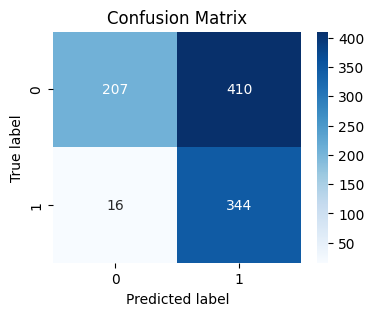

In [ ]:
# previous best: eval_on f1 , best_metric=0.7669682977041087
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    path_for_resuming = 'artifacts/MHIST_ViT_v1.pt', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = another_model, # if not resuming, new FC model is initialized to random
    model_type='VIT',
    batch_size = 960, # 512 if torch.cuda.is_available() else 4,
    eval_on='recall', # for positive (minority) class
    enable_tracking = True,
    # logger=None,
    )

best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    # freeze_all_but_head = True,
    learning_rate = 1e-5,
    best_metric = 0.975,
    best_model_dest = "artifacts/MHIST_ViT_v2.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

In [ ]:
!nvidia-smi # 10.2 GB

Wed Jun 26 10:57:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   73C    P0              35W /  72W |  10245MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Layer 1:
  frozen
Layer 2:
  no tensors
Layer 3:
  no tensors
Layer 4:
  no tensors
Layer 5:
  frozen
Layer 6:
  frozen
Layer 7:
  no tensors
Layer 8:
  no tensors
Layer 9:
  tensors that require grad: 2/2
-------------------------------
Training 1 layers of 9 total
Evaluating the model on recall best_metric = 0.2611111111111111
Initial learning rate 0.001

Logging metrics with server: http://ec2-3-101-21-63.us-west-1.compute.amazonaws.com:5000
MLflow: run_name = shivering-worm-829 run_id = 36bf8fc8ca8b4d8c8788a9b6e74c6099
MLflow Experiment name: MHIST ViT (binary classification) 

Device: cuda:0


100%|██████████| 5/5 [06:32<00:00, 78.41s/it]


Epoch 1 train Loss: 0.683, recall: 0.7212669683257918, Accuracy: 0.590
Epoch 1 train: Learning rate changed to 0.001000


100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Improved validation recall: 0.975
Saving model weights to artifacts/MHIST_ViT_v1.pt
Epoch 1 val Loss: 0.749, val_recall: 0.975, Accuracy: 0.553
Epoch 0 completed in 6m 43s


100%|██████████| 5/5 [03:15<00:00, 39.00s/it]


Epoch 2 train Loss: 0.586, recall: 0.8648148148148148, Accuracy: 0.695


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Epoch 2 val Loss: 0.541, val_recall: 0.7722222222222223, Accuracy: 0.705


100%|██████████| 5/5 [01:49<00:00, 21.90s/it]


Epoch 3 train Loss: 0.521, recall: 0.6920877025738799, Accuracy: 0.743


100%|██████████| 2/2 [00:09<00:00,  4.56s/it]


Epoch 3 val Loss: 0.502, val_recall: 0.7388888888888889, Accuracy: 0.736


100%|██████████| 5/5 [01:00<00:00, 12.09s/it]


Epoch 4 train Loss: 0.504, recall: 0.7592067988668555, Accuracy: 0.757
Epoch 4 train: Learning rate changed to 0.000100


100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Epoch 4 val Loss: 0.548, val_recall: 0.9055555555555556, Accuracy: 0.705


100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


Epoch 5 train Loss: 0.490, recall: 0.8356417359187442, Accuracy: 0.760


100%|██████████| 2/2 [00:09<00:00,  4.58s/it]


Epoch 5 val Loss: 0.549, val_recall: 0.9083333333333333, Accuracy: 0.703


100%|██████████| 5/5 [00:36<00:00,  7.33s/it]


Epoch 6 train Loss: 0.476, recall: 0.8479477611940298, Accuracy: 0.766


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Epoch 6 val Loss: 0.544, val_recall: 0.9027777777777778, Accuracy: 0.704


100%|██████████| 5/5 [00:26<00:00,  5.39s/it]


Epoch 7 train Loss: 0.458, recall: 0.8566001899335233, Accuracy: 0.774


100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Epoch 7 val Loss: 0.533, val_recall: 0.8888888888888888, Accuracy: 0.713


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


Epoch 8 train Loss: 0.471, recall: 0.8279370952821462, Accuracy: 0.782


100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Epoch 8 val Loss: 0.523, val_recall: 0.8722222222222222, Accuracy: 0.725


100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Epoch 9 train Loss: 0.481, recall: 0.823963133640553, Accuracy: 0.771
Epoch 9 train: Learning rate changed to 0.000010


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Epoch 9 val Loss: 0.516, val_recall: 0.8722222222222222, Accuracy: 0.733


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


Epoch 10 train Loss: 0.464, recall: 0.818957345971564, Accuracy: 0.775


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Epoch 10 val Loss: 0.515, val_recall: 0.8722222222222222, Accuracy: 0.733
Training complete in 17m 3s
Best recall score: 0.975
Learning rate: start=1e-06 final=1e-05
[[402 215]
 [ 46 314]]
              precision    recall  f1-score   support

         0.0       0.90      0.65      0.75       617
         1.0       0.59      0.87      0.71       360

    accuracy                           0.73       977
   macro avg       0.75      0.76      0.73       977
weighted avg       0.79      0.73      0.74       977



AttributeError: 'TrainingSession' object has no attribute '_TrainingSession__log_best_model'

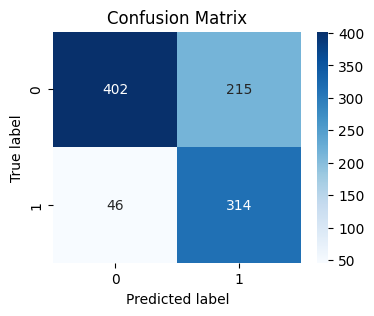

In [ ]:
best_ViT = session.train_and_evaluate(
    # model = None, # (optional) pass a model to freeze/unfreeze, check, or change anything between runs
    epochs = 10,
    # freeze_all_but_head = True,
    learning_rate = 1e-3,
    best_metric = 0.2611111111111111,
    best_model_dest = "artifacts/MHIST_ViT_v1.pt",  # DEFAULT_MODEL_PATH = 'MHIST_model.pt'
    mlflow_experiment = "MHIST ViT (binary classification)",
    #  mlflow_run = None # create a new run
    )

### Run batch inference on best model
After training, I ran batch inference on the test set with the best ViT model to inspect the results more carefully, checking for inaccurate classification and comparing the expert labeling with the results.

In [8]:
session = TrainingSession(
    # train_transform=None,
    # val_transform=None,
    path_for_resuming = 'artifacts/MHIST_ViT_v13.pt', # resume from local path if not None (not used for saving best model)
    # resume_from_object = False, # resume from model object
    # model = None, # if not resume_from_object, model is initialized to random
    model_type = 'VIT',
    batch_size = 960,
    # eval_on='loss',
    # enable_tracking=False,
    # logger=None,
    )
results_df, metrics = session.batch_predict()

# # Save
# results_df.to_csv('artifacts/MHIST_ViT_v13_results.csv', index=False)
# pd.Series(metrics).to_json('artifacts/MHIST_ViT_v13_metrics.json')

# For samples that have a negative prediction (pred class HP),
# correct the probability to be = 1 - positive_prob
corrected_results_df = results_df.copy()
corrected_results_df['prob'] = corrected_results_df['positive_prob']
neg_pred_samples = corrected_results_df['prediction'] == 0
corrected_results_df.loc[neg_pred_samples, 'prob'] = 1 - corrected_results_df.loc[neg_pred_samples, 'prob']

# Info about false negatives
incorrect_df = corrected_results_df[(corrected_results_df['correct'] == 0) & (corrected_results_df['prob']>0.5) & (corrected_results_df['label']==1)]
incorrect_annotations = incorrect_df.merge(annotations, left_on='filename', right_on='Image Name', how='left')
cols = ['filename', 'label', 'prediction', 'positive_prob', 'prob', 'Number of Annotators who Selected SSA (Out of 7)']
expert_comparison_df = incorrect_annotations.loc[incorrect_annotations['Number of Annotators who Selected SSA (Out of 7)']>5, cols]

# Display model results and false negative info
metrics, corrected_results_df.info(), corrected_results_df.head(), incorrect_annotations[cols], expert_comparison_df

Setting up data:
Using ViT transforms
No training set. Model is ready for inference on 977 samples.
batch_size 960 val_num_batches 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Allocating a new model from timm: vit_base_patch16_224 with pretrained weight tag: augreg2_in21k_ft_in1k
Info: Resuming from saved state dict artifacts/MHIST_ViT_v13.pt on device cuda
Loading a copy of initial model weights into memory


100%|██████████| 2/2 [06:48<00:00, 204.47s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       977 non-null    string 
 1   label          977 non-null    Int64  
 2   logit          977 non-null    float64
 3   prediction     977 non-null    Int64  
 4   positive_prob  977 non-null    float64
 5   correct        977 non-null    Int64  
 6   prob           977 non-null    float64
dtypes: Int64(3), float64(3), string(1)
memory usage: 56.4 KB


({'weighted_precision': 0.8016439744562481,
  'weighted_recall': 0.744114636642784,
  'weighted_f1': 0.7479091167791236,
  'accuracy': 0.744114636642784,
  'balanced_accuracy': 0.776580226904376,
  'roc_auc': 0.5,
  'pr_auc': 0.368474923234391,
  'false_negative_rate': 0.1,
  'true_positive_rate': 0.9},
 None,
         filename  label     logit  prediction  positive_prob  correct  \
 0  MHIST_aag.png      0  0.619879           1       0.650191        0   
 1  MHIST_aah.png      0  3.955299           1       0.981207        0   
 2  MHIST_aaq.png      1 -1.511626           0       0.180698        0   
 3  MHIST_aar.png      0 -1.113702           0       0.247181        1   
 4  MHIST_aay.png      0 -0.942191           0       0.280458        1   
 
        prob  
 0  0.650191  
 1  0.981207  
 2  0.819302  
 3  0.752819  
 4  0.719542  ,
          filename  label  prediction  positive_prob      prob  \
 0   MHIST_aaq.png      1           0       0.180698  0.819302   
 1   MHIST_amm.png 

Evaluating thresholds: 100%|██████████| 99/99 [00:00<00:00, 128.64it/s]



Best threshold for weighted_precision:
Threshold: 0.76
Weighted Precision: 0.8198
Weighted Recall: 0.8178
Weighted F1: 0.8186
Accuracy: 0.8178
Balanced Accuracy: 0.8089
ROC AUC: 0.8764
PR AUC: 0.8070
False Negative Rate: 0.2250
True Positive Rate: 0.7750

Best threshold for weighted_recall:
Threshold: 0.76
Weighted Precision: 0.8198
Weighted Recall: 0.8178
Weighted F1: 0.8186
Accuracy: 0.8178
Balanced Accuracy: 0.8089
ROC AUC: 0.8764
PR AUC: 0.8070
False Negative Rate: 0.2250
True Positive Rate: 0.7750

Best threshold for weighted_f1:
Threshold: 0.76
Weighted Precision: 0.8198
Weighted Recall: 0.8178
Weighted F1: 0.8186
Accuracy: 0.8178
Balanced Accuracy: 0.8089
ROC AUC: 0.8764
PR AUC: 0.8070
False Negative Rate: 0.2250
True Positive Rate: 0.7750

Best threshold for accuracy:
Threshold: 0.76
Weighted Precision: 0.8198
Weighted Recall: 0.8178
Weighted F1: 0.8186
Accuracy: 0.8178
Balanced Accuracy: 0.8089
ROC AUC: 0.8764
PR AUC: 0.8070
False Negative Rate: 0.2250
True Positive Rate: 0.7

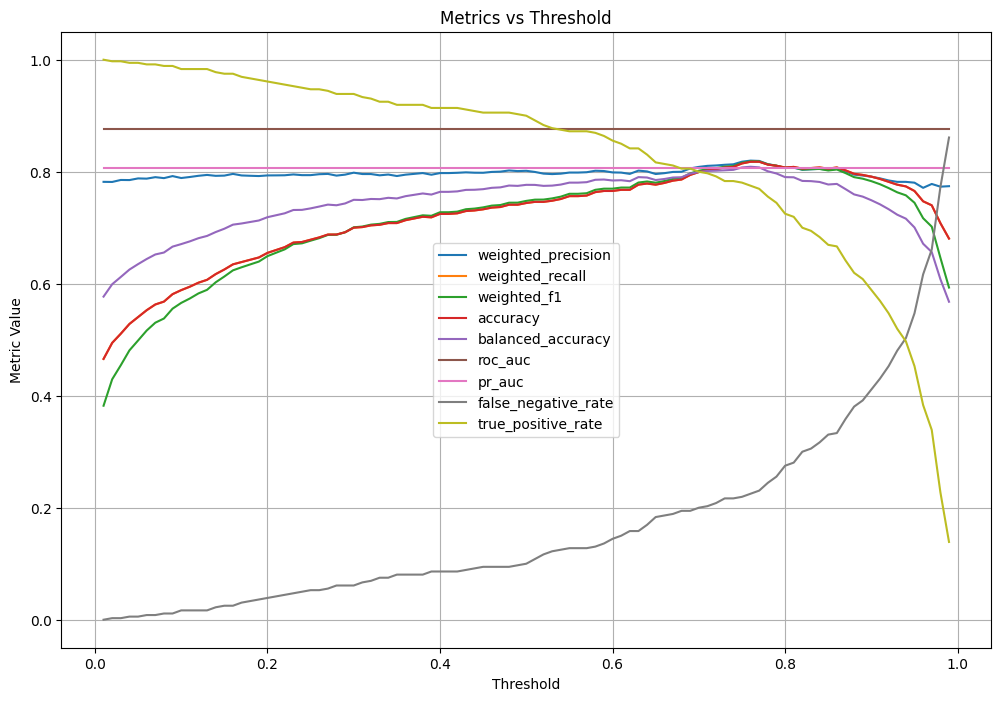

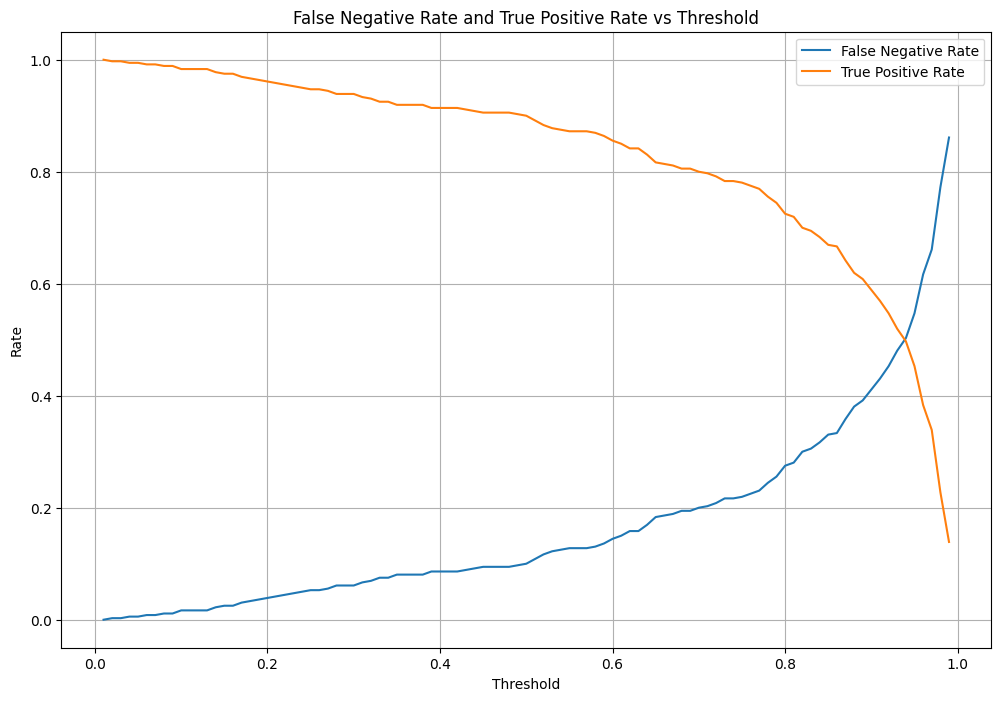


Threshold that minimizes False Negative Rate: 0.01
Metrics at this threshold:
threshold              0.010000
weighted_precision     0.781923
weighted_recall        0.465711
weighted_f1            0.382134
accuracy               0.465711
balanced_accuracy      0.576985
roc_auc                0.876391
pr_auc                 0.806982
false_negative_rate    0.000000
true_positive_rate     1.000000


In [ ]:
# Get metrics on different thresholds for a given dataset
# The dataframe is hard-coded in RESULTS_DF, below
# Code is from Perplexity.ai

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score, balanced_accuracy_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

RESULTS_DF = corrected_results_df

def evaluate_threshold(y, y_prob, threshold):
    y_true = y.astype(int)
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    return {
        'threshold': threshold,
        'weighted_precision': precision_score(y_true, y_pred, average='weighted'),
        'weighted_recall': recall_score(y_true, y_pred, average='weighted'),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'pr_auc': average_precision_score(y_true, y_prob),
        'false_negative_rate': fnr,
        'true_positive_rate': tpr
    }

def find_best_thresholds(df):
    y_true = df['label'].values
    y_prob = df['positive_prob'].values

    thresholds = np.arange(0.01, 1.00, 0.01)  # Expanded range
    metrics = []

    for threshold in tqdm(thresholds, desc="Evaluating thresholds"):
        metrics.append(evaluate_threshold(y_true, y_prob, threshold))

    metrics_df = pd.DataFrame(metrics)

    best_thresholds = {
        'weighted_precision': metrics_df.loc[metrics_df['weighted_precision'].idxmax()],
        'weighted_recall': metrics_df.loc[metrics_df['weighted_recall'].idxmax()],
        'weighted_f1': metrics_df.loc[metrics_df['weighted_f1'].idxmax()],
        'accuracy': metrics_df.loc[metrics_df['accuracy'].idxmax()],
        'balanced_accuracy': metrics_df.loc[metrics_df['balanced_accuracy'].idxmax()],
        'roc_auc': metrics_df.loc[metrics_df['roc_auc'].idxmax()],
        'pr_auc': metrics_df.loc[metrics_df['pr_auc'].idxmax()],
        'false_negative_rate': metrics_df.loc[metrics_df['false_negative_rate'].idxmin()]
    }

    return best_thresholds, metrics_df

# Run the analysis on the cleaned data
best_thresholds, metrics_df = find_best_thresholds(RESULTS_DF)

# Print the results
for metric, row in best_thresholds.items():
    print(f"\nBest threshold for {metric}:")
    print(f"Threshold: {row['threshold']:.2f}")
    print(f"Weighted Precision: {row['weighted_precision']:.4f}")
    print(f"Weighted Recall: {row['weighted_recall']:.4f}")
    print(f"Weighted F1: {row['weighted_f1']:.4f}")
    print(f"Accuracy: {row['accuracy']:.4f}")
    print(f"Balanced Accuracy: {row['balanced_accuracy']:.4f}")
    print(f"ROC AUC: {row['roc_auc']:.4f}")
    print(f"PR AUC: {row['pr_auc']:.4f}")
    print(f"False Negative Rate: {row['false_negative_rate']:.4f}")
    print(f"True Positive Rate: {row['true_positive_rate']:.4f}")

# Plot the metrics across thresholds
plt.figure(figsize=(12, 8))
for column in metrics_df.columns:
    if column != 'threshold':
        plt.plot(metrics_df['threshold'], metrics_df[column], label=column)
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Plot focusing on False Negative Rate and True Positive Rate
plt.figure(figsize=(12, 8))
plt.plot(metrics_df['threshold'], metrics_df['false_negative_rate'], label='False Negative Rate')
plt.plot(metrics_df['threshold'], metrics_df['true_positive_rate'], label='True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('False Negative Rate and True Positive Rate vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold that minimizes False Negative Rate
min_fnr_threshold = metrics_df.loc[metrics_df['false_negative_rate'].idxmin(), 'threshold']
print(f"\nThreshold that minimizes False Negative Rate: {min_fnr_threshold:.2f}")
print("Metrics at this threshold:")
print(metrics_df.loc[metrics_df['threshold'] == min_fnr_threshold].iloc[0].to_string())


In [ ]:
# Save metrics for a new threshold for a given dataset
# Set RESULTS_DF and THRESHOLD below
# Code is from Perplexity.ai

import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score

RESULTS_DF = corrected_results_df
THRESHOLD = 0.3

# Create the new DataFrame with adjusted predictions
adjusted_threshold_df = results_df.copy()
adjusted_threshold_df['prediction'] = (adjusted_threshold_df['positive_prob'] >= THRESHOLD).astype(int)
adjusted_threshold_df['correct'] = (adjusted_threshold_df['prediction'] == adjusted_threshold_df['label']).astype(int)
adjusted_threshold_df['prob'] = np.where(adjusted_threshold_df['prediction'] == 0,
                                         1 - adjusted_threshold_df['positive_prob'],
                                         adjusted_threshold_df['positive_prob'])

# Calculate metrics
y_true = adjusted_threshold_df['label']
y_pred = adjusted_threshold_df['prediction']
y_prob = adjusted_threshold_df['positive_prob']

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

metrics = {
    'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
    'weighted_recall': recall_score(y_true, y_pred, average='weighted'),
    'False Negative Rate': fn / (fn + tp),
    'True Positive Rate': tp / (tp + fn),
    'Weighted F1-Score': f1_score(y_true, y_pred, average='weighted'),
    'Accuracy': accuracy_score(y_true, y_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
    'ROC-AUC': roc_auc_score(y_true, y_prob),
    'PR-AUC': average_precision_score(y_true, y_prob)
}

# # Save the adjusted DataFrame to CSV
# adjusted_threshold_df.to_csv('artifacts/MHIST_ViT_v13_adjusted_threshold_results.csv', index=False)

# # Save metrics to a separate file
# pd.Series(metrics).to_json('artifacts/MHIST_ViT_v13_adjusted_threshold_metrics.json')

# Show metrics and new results
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
adjusted_threshold_df

Weighted Precision: 0.7983
False Negative Rate: 0.0611
True Positive Rate: 0.9389
Weighted F1-Score: 0.7007
Accuracy: 0.7001
Balanced Accuracy: 0.7498
ROC-AUC: 0.8764
PR-AUC: 0.8070


,filename,label,logit,prediction,positive_prob,correct,prob
0,MHIST_aag.png,0,0.619876,1,0.650190,0,0.650190
1,MHIST_aah.png,0,3.955307,1,0.981207,0,0.981207
2,MHIST_aaq.png,1,-1.511615,0,0.180700,0,0.819300
3,MHIST_aar.png,0,-1.113706,0,0.247181,1,0.752819
4,MHIST_aay.png,0,-0.942173,0,0.280462,1,0.719538
...,...,...,...,...,...,...,...
972,MHIST_eqz.png,1,4.235839,1,0.985739,1,0.985739
973,MHIST_edm.png,1,3.252985,1,0.962780,1,0.962780
974,MHIST_blw.png,1,-1.286322,0,0.216476,0,0.783524
975,MHIST_cfc.png,1,4.280223,1,0.986349,1,0.986349


## Export to ONNX
PyTorch does a lot of the work of converting models to ONNX. The new Dynamo export method integrates with ONNX to make conversion simple as well as efficient and accurate. I only selectively log models to MLflow to avoid uneccessary fees from AWS for data transfer and storage, which can add up quickly with large models.

In [ ]:
# Test ViT inference with the best model (PyTorch):
!pip install -q timm # CPU-only version: pip install timm[torch-cpu]
import timm
vit = timm.create_model(
    model_name='vit_base_patch16_224',
    pretrained=False,
    num_classes=1, # change number of outputs in classification head
    # img_size=224
)
print('vit.head:\n', vit.head) # Linear(in_features=768, out_features=1, bias=True)

import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
PYTORCH_MODEL_PATH = 'artifacts/MHIST_ViT_v13.pt'
IMAGES_DIR = 'images/'
PATH = 'MHIST_aah.png'
test_df = pd.read_csv('artifacts/testset_info.csv')

label = 'SSA' if test_df.loc[test_df['name'] == PATH, 'label'].item() == 1 else 'HP'

image_path = os.path.join(IMAGES_DIR, PATH)
image_PIL = Image.open(image_path).convert('RGB') # PIL Image size (224, 224)
print('\nimage_PIL dimensions', image_PIL.size)

# Mean and std values were calculated from the training data, to normalize the colors (per channel):
# Model expects the shape to be [BATCH, 3, 224, 224]
TRAIN_MEAN = [0.738, 0.649, 0.775]
TRAIN_STD =  [0.197, 0.244, 0.17]
MHIST_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD),
])

preprocessed_image = MHIST_transforms(image_PIL)
print('preprocessed_image shape', preprocessed_image.shape)

# Load model weights from PyTorch model checkpoint
vit.load_state_dict(torch.load(PYTORCH_MODEL_PATH, map_location=torch.device('cpu'))) # load model from disk, specify the location for mapping (loading) the model's params
vit.eval()

with torch.no_grad():
    logit = vit(preprocessed_image.unsqueeze(0)) # torch.Size([1, 3, 224, 224]) with dtype = torch.float32
    print('4D image.shape', preprocessed_image.unsqueeze(0).shape)
    print('\nlogit =', logit.item())
    pred = logit.item() > 0 # Python bool
    prob = torch.sigmoid(logit).item()
    print('pred =', 'SSA' if pred else 'HP')
    print('probability', prob if pred else 1-prob)
print('label =', label)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 88.6 MB/s eta 0:00:00
vit.head:
 Linear(in_features=768, out_features=1, bias=True)
image_PIL dimensions (224, 224)
preprocessed_image shape torch.Size([3, 224, 224])
4D image.shape torch.Size([1, 3, 224, 224])
logit = 3.948850393295288
pred = SSA
probability 0.9810876846313477
label = HP


In [ ]:
# Export PyTorch model to ONNX
!pip install --upgrade onnx onnxscript
import torch.onnx

# Generate an example input (image)
example_input = torch.randn(224, 224, 3) # Tensor size (224, 224, 3)
example_preprocessed = MHIST_transforms(example_input.numpy()) # includes ToTensor
print('example_preprocessed shape', example_preprocessed.shape) # torch.Size([3, 224, 224])

# Export to ONNX (with Dynamo)
onnx_program = torch.onnx.dynamo_export(vit, example_preprocessed.unsqueeze(0))
onnx_program.save("artifacts/MHIST_ViT_v13_dynamo_model.onnx")
onnx_program.model_proto.graph.input[0]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.9/640.9 kB 57.3 MB/s eta 0:00:00
example_preprocessed shape torch.Size([3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/exporter.py:136: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


name: "l_x_"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}

In [ ]:
# Test inference with local (not EFS) ONNX Dynamo model and S3
# !pip install torch onnx
!pip install -q onnxruntime
import time
import json
from io import BytesIO
from PIL import Image
import numpy as np

# PYTORCH_MODEL_PATH = 'artifacts/MHIST_ViT_v13.pt'
# IMAGES_DIR = 'images/'
# PATH = 'MHIST_aah.png'

import boto3
S3_BUCKET = "mhist-streamlit-app"
S3_ORIGINALS_DIR = "images/original/"
image_filename = 'MHIST_aah.png'

# For inference
from onnxruntime import InferenceSession
EFS_ACCESS_POINT = os.getcwd()
MODEL_PATH = "artifacts/MHIST_ViT_v13_dynamo_model.onnx"

def standardize_image(np_image):
    # Convert lists to numpy
    np_mean = np.array(TRAIN_MEAN, dtype=np.float32).reshape(3, 1, 1) # np_mean.shape (3, 1, 1)
    np_std = np.array(TRAIN_STD, dtype=np.float32).reshape(3, 1, 1) # np_std.shape (3, 1, 1)

    # Normalize: operations are performed element-wise using NumPy broadcasting
    np_image = (np_image - np_mean) / np_std
    return np_image


# Images are normalized to range [0., 1.] and standardized by channel
def preprocess(image_filename):
    # Download image (png file) as bytes from S3
    image_s3key = os.path.join(S3_ORIGINALS_DIR, image_filename)
    s3 = boto3.client('s3')
    file_obj = s3.get_object(Bucket=S3_BUCKET, Key=image_s3key)
    image_bytes = BytesIO(file_obj['Body'].read())

    # Convert bytes (buffer) to 3-channels, then to ndarray
    # We could do this without PIL (using only NumPy)
    pil_image = Image.open(image_bytes).convert('RGB') # pil_image.size (224, 224) with 3 channels
    np_image = np.array(pil_image, dtype=np.float32) # np_image shape (224, 224, 3) dtype float32
    transposed_np = np.transpose(np_image, (2, 0, 1)) # shape (3, 224, 224) max pixel value = 255.
    normalized_np = transposed_np / 255.0 # normalize range to [0., 1.]
    standardized_np = standardize_image(normalized_np) # normalize color-channels
    return np.expand_dims(standardized_np, axis=0)


def sigmoid(np_outs):
    np_outs = np.clip(np_outs, -50, 50) # prevent np.exp overflow for large values
    return 1 / (1 + np.exp(-np_outs))


def predict(image_filename): # image_url <class '_io.BytesIO'>
    print('EFS_ACCESS_POINT contents:', os.listdir(EFS_ACCESS_POINT))

    # Run inference with optimized ONNX model
    # It only uses 3.3 GB CPU memory, and 1.4 GB space (for artifacts)
    onnx_path = os.path.join(EFS_ACCESS_POINT, MODEL_PATH)
    ort_session = InferenceSession(os.path.abspath(onnx_path))#, providers=['CPUExecutionProvider'])

    start_inference = time.monotonic()
    preprocessed_image = preprocess(image_filename)
    preprocess_time = time.monotonic()
    input_name = ort_session.get_inputs()[0].name
    ort_outs = ort_session.run(None, {input_name: preprocessed_image}) # output: [array([-1.2028292], dtype=float32)]
    inference_time = time.monotonic()

    logit = ort_outs[0].item() # <class 'numpy.ndarray'> shape (1,) dtype=float32
    positive_prob = sigmoid(logit).item()
    pred = positive_prob > 0.3
    inference_info = {#json.dumps({
        'logit': logit,
        'predicted_class': 'SSA' if pred else 'HP',
        'probability': positive_prob if pred else 1-positive_prob,
        'preprocess_time': preprocess_time-start_inference,
        'inference_time': inference_time-preprocess_time,
        }
    return inference_info


post_start = time.monotonic()
r_dict = predict(image_filename)
onnx_runtime = time.monotonic() - post_start

print('Completed inference on image_filename', image_filename, 'logit', r_dict['logit'])
print('inference_info:\n', r_dict)

correct = r_dict['predicted_class'] == 'HP'
class_type = 'positive' if r_dict['predicted_class'] == 'SSA' else 'negative'
print(f"Prediction: {r_dict['predicted_class']}, which is a {str(correct).lower()} {class_type}")
print(f"Model's predicted probability: {r_dict['probability']*100:.2f}%")
print(f"Preprocessed image in {r_dict['preprocess_time']:.2f} seconds")
print(f"Classified image in {r_dict['inference_time']:.2f} seconds")
print(f"Total: {int(round(onnx_runtime))} seconds")


EFS_ACCESS_POINT contents: ['annotations.csv', 'images.zip', 'MD5SUMs.txt', '.ipynb_checkpoints', 'images', 'MHIST_model', 'MHIST_FCN_model', 'MHIST_resnet18_model', 'MHIST_vit_model', 'synthetic', 'synthetic_metadata.csv', 'MHIST_vit_bal_model', 'MHIST_resnet18_bal_model', 'MHIST_pretrained_resnet18_bal_model', 'MHIST_resnet18_over_model', 'MHIST_vit_over_model', 'MHIST_FCN_bal_model', 'Project: Results.gsheet', 'MHIST_FCN_over_model', 'Project Scratch Notebook: Gastrointestinal Images.ipynb', 'MHIST_FCN_under_model', 'MHIST- Model Output Results.gdoc', 'Project Submission: Gastrointestinal Images.ipynb', 'artifacts', 'mlruns', 'Project Statement: Gastrointestinal Images Classification.gdoc', 'Capstone Project Proposal.gdoc', 'MHIST 3 - FCN.ipynb', 'MHIST 2.ipynb', 'report_dynamo_export.sarif', 'MHIST- ML Ops  Notes.gdoc', 'MHIST 4 - ViT.ipynb']
Loading model from /content/drive/MyDrive/Colab Notebooks/projects/MHIST/artifacts/MHIST_ViT_v13_dynamo_model.onnx
pil_image dimensions (224,

In [ ]:
# Log best ViT model (as a generic artifact) to MLflow server
# import mlflow
print('Using:', 'boto3', boto3.__version__, 'mlflow', mlflow.__version__)#, 'onnx', onnx.__version__)

MLFLOW_SERVER="http://13.52.243.246:5000"
MLFLOW_EXPERIMENT = 'MHIST ViT (binary classification)'
DYNAMO_MODEL_PATH = "artifacts/MHIST_ViT_v13_dynamo_model.onnx"
MLFLOW_MODEL_PATH = 'onnx_artifacts'

mlflow.set_tracking_uri(MLFLOW_SERVER)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
run_id = '84074e5ab58749f1b609ef5ef90c499f'
# run_name = masked-sheep-165

with mlflow.start_run(run_id) as run: #any active run will be ended
    print('\nLogging metrics and best model with MLflow: run_name =', run.info.run_name, 'run_id =', run.info.run_id) # run_id is a UUID
    print('MLflow server:', mlflow.get_tracking_uri())
    mlflow.log_artifact(DYNAMO_MODEL_PATH, artifact_path=MLFLOW_MODEL_PATH)
    print('Artifacts stored at:', mlflow.get_artifact_uri())


Using: boto3 1.34.138 mlflow 2.14.1

Logging metrics and best model with MLflow: run_name = masked-sheep-165 run_id = 84074e5ab58749f1b609ef5ef90c499f
MLflow server: http://13.52.243.246:5000
Artifacts stored at: s3://mlflow-artifacts-image-quality/mlartifacts/7/84074e5ab58749f1b609ef5ef90c499f/artifacts
